In [91]:
import os
import json

import numpy as np
import pandas as pd
import random
from collections import Counter
import math
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from collections import Counter

import sklearn.cluster

import torch
from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec

from tqdm import tqdm

from scipy import stats
from scipy.spatial import distance
from scipy.stats import pearsonr
import statsmodels.api as sm

In [12]:
def entropy(data):
    counts = Counter(data)
    total = len(data)

    entropy_value = -sum((count / total) * math.log2(count / total) for count in counts.values())

    return entropy_value

In [649]:
df_pw.to_csv("./df_pw.csv", index=False)
df_pw_f.to_csv("./df_pw_f.csv", index=False)
df_pw_l.to_csv("./df_pw_l.csv", index=False)

In [2]:
identifiers_l = os.listdir("./Identifier")
iu2smile = {}
for i in identifiers_l:
    df_o = pd.read_csv(os.path.join("./Identifier/", i))
    for idx, row in df_o.iterrows():
        iu2smile[row.iloc[0]] = row.iloc[1]
len(iu2smile.keys())

iupac = []
smiles = []
for i in iu2smile.keys():
    iupac.append(i)
    smiles.append(iu2smile[i])
pd.DataFrame({
    'iupac': iupac,
    'smiles': smiles
}).to_csv('./Identifier/Chem_sm.csv', index=False)

len(iupac)

10741

In [23]:
df_para = pd.read_csv("./CTD_PMid_f.csv", sep="$")
df_exp = pd.read_csv("./df_ctd_ad.csv", sep="$")
df_para["cluster"] = df_exp["cluster"]
df_para = df_para.dropna(subset=['authors', 'entities'], how='any')

df_para["f_auth"] = [int(str(x).split(',')[0]) for x in df_para["authors"]]
df_para["l_auth"] = [int(str(x).split(',')[-1]) for x in df_para["authors"]]

df_para

,pmid,year,abstract_text,affiliation,authors,pub_ages,pub_orders,entities,cluster,f_auth,l_auth
0,706,1976,Thirteen out of 18 young out-patients with sim...,NaN,"6080788,5580950","2,0","1,2","260079301,260079301,0,256846301,257196101,3082...",577,6080788,5580950
1,1803,1976,Mice were given a drug per os and 2 h later we...,NaN,4785193,15,1,"254194001,254194001,304309303,4784103,4853703,...",667,4785193,4785193
2,1959,1976,"In a double-blind trial lasting 2 weeks, a new...",NaN,"5345734,6289591,8234202,756055","21,27,28,24","1,2,3,4","260202601,107368601,0,7600703,7600703,7600703,...",13,5345734,756055
3,2004,1976,Eight patients had cardiac manifestations that...,NaN,"3434361,2020640,2769654,2460523,1048829","29,7,18,15,24","1,2,3,4,5","256349801,106988801,258380301,255367101,255458...",446,3434361,1048829
4,2127,1976,Beta-Adrenergic stimulation with isoproterenol...,NaN,"8714268,3466728,8417281","7,14,26","1,2,3","4206703,6293303,6293303,6293303,4133203,629330...",234,8714268,8417281
...,...,...,...,...,...,...,...,...,...,...,...
26657,4938432,1971,One hundred and three children with proved typ...,NaN,"3202732,1393129","19,11","1,2","106936401,106936401,106936401,4253703,99516003...",13,3202732,1393129
26658,4945727,1972,1. Injection of 0.5-2.0 units of vasopressin o...,NaN,"7297630,1687865","0,14","1,2","260959401,260959401,260959401,260959401,260959...",388,7297630,1687865
26659,4951148,1986,Severe intrahepatic cholestasis occurred 13 mo...,NaN,"1259505,8765361,3327169","5,0,19","1,2,3","107286901,107286901,107420801,106984201,255128...",720,1259505,3327169
26660,4973764,1969,The results of treatment of 25 patients admitt...,NaN,4459668,5,1,"106984001,106984001,106908201,106985901,106985...",139,4459668,4459668


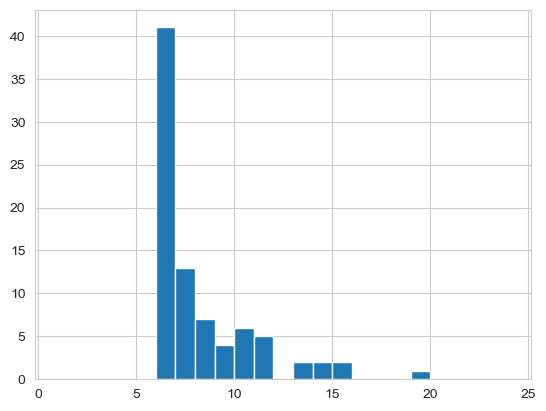

22192 20915


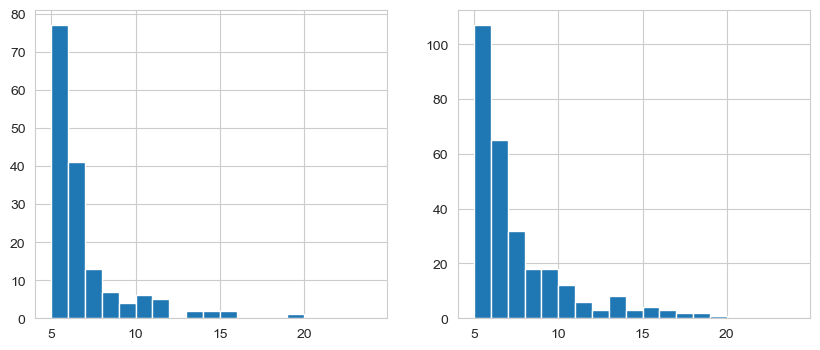

In [301]:
df_para_mid = df_para[df_para["authors"].apply(lambda x: len(x.split(',')) > 2)].copy()
df_para_mid['mid_authors'] = df_para_mid["authors"].apply(lambda x: x.split(',')[1:-1])
mid_authors = []
for i in df_para_mid['mid_authors']:
    mid_authors.extend(i)
mid_author_counts = sorted(Counter(df_para.f_auth).items(), key=lambda x: x[1], reverse=True)
plt.hist([x[1] for x in mid_author_counts if x[1] > 5], bins=range(1, 25))
plt.show()

f_auth_counts = sorted(Counter(df_para.f_auth).items(), key=lambda x: x[1], reverse=True)
l_auth_counts = sorted(Counter(df_para.l_auth).items(), key=lambda x: x[1], reverse=True)

print(len(f_auth_counts), len(l_auth_counts))

fig = plt.figure(figsize=(10, 4))
ax_a = fig.add_subplot(1, 2, 1)
ax_a.hist([x[1] for x in f_auth_counts if x[1] >= 5], bins=range(5, 25))

ax_l = fig.add_subplot(1, 2, 2)
ax_l.hist([x[1] for x in l_auth_counts if x[1] >= 5], bins=range(5, 25))

plt.show()

In [26]:
df_para.to_csv("./CTD_PMid_para.csv", sep="$", index=False)

22192 20915


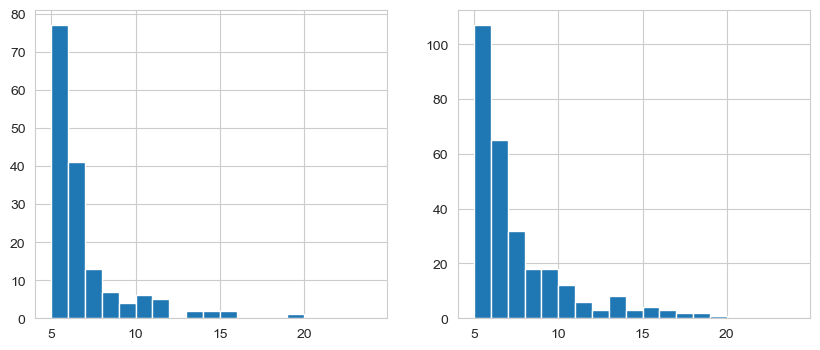

In [38]:
f_auth_counts = sorted(Counter(df_para.f_auth).items(), key=lambda x: x[1], reverse=True)
l_auth_counts = sorted(Counter(df_para.l_auth).items(), key=lambda x: x[1], reverse=True)

print(len(f_auth_counts), len(l_auth_counts))

fig = plt.figure(figsize=(10, 4))
ax_a = fig.add_subplot(1, 2, 1)
ax_a.hist([x[1] for x in f_auth_counts if x[1] >= 5], bins=range(5, 25))

ax_l = fig.add_subplot(1, 2, 2)
ax_l.hist([x[1] for x in l_auth_counts if x[1] >= 5], bins=range(5, 25))

plt.show()

In [142]:
text_df = pd.read_csv("./embedded_Pmid_para.csv")
text_df["ada_embedding"] = text_df["ada_embedding"].apply(lambda x: [float(i) for i in x[1:-1].split(',')])

chem_dis = pd.read_csv("./CTD/CTD_chemicals_diseases.csv", comment='#', low_memory=False)
chem_sm = pd.read_csv("./Identifier/Chem_sm.csv")
chem_dis_p = chem_dis[(chem_dis["ChemicalName"].isin(set(chem_sm["iupac"]))) & chem_dis["PubMedIDs"]]
smile_df = pd.read_csv("./Chem_sm_embd.csv")
chem_dis_p

,ChemicalName,ChemicalID,CasRN,DiseaseName,DiseaseID,DirectEvidence,InferenceGeneSymbol,InferenceScore,OmimIDs,PubMedIDs
69,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,NaN,Adenocarcinoma,MESH:D000230,NaN,KCNQ1,4.70,NaN,23975432
70,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,NaN,Amphetamine-Related Disorders,MESH:D019969,NaN,FOS,4.15,NaN,19689456
71,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,NaN,Amyotrophic lateral sclerosis 1,MESH:C531617,NaN,FOS,4.62,NaN,11796754
72,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,NaN,Anxiety Disorders,MESH:D001008,NaN,FOS,3.72,NaN,16488545
73,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,NaN,"Arthritis, Juvenile",MESH:D001171,NaN,FOS,4.14,NaN,19565504
...,...,...,...,...,...,...,...,...,...,...
8787885,zymosterol,C015582,128-33-6,Autism Spectrum Disorder,MESH:D000067877,NaN,CYP27A1,4.84,NaN,35663546
8787886,zymosterol,C015582,128-33-6,"Bone Diseases, Metabolic",MESH:D001851,NaN,CYP27A1,5.94,NaN,24381012
8787887,zymosterol,C015582,128-33-6,Cholestasis,MESH:D002779,NaN,CYP27A1,4.84,NaN,15795599
8787888,zymosterol,C015582,128-33-6,Liver Cirrhosis,MESH:D008103,NaN,CYP27A1,4.90,NaN,24381012


In [456]:
pubMeds = []
chem_names = []

set_pm = set(df_para['pmid'])
set_chem = set(smile_df['iupac'])

for idx, row in chem_dis_p.iterrows():

    for i in row["PubMedIDs"].split('|'):
        pm = int(i)
        if pm in set_pm and row["ChemicalName"] in set_chem:
            pubMeds.append(pm)
            chem_names.append(row["ChemicalName"])

df_p2c = pd.DataFrame({
    "pmid": pubMeds,
    "chem_name": chem_names
})
df_p2c.to_csv("./df_p2c.csv", index=False)

len(df_p2c), len(df_p2c.pmid.unique()), len(df_p2c.chem_name.unique())

(878232, 23384, 8728)

In [543]:
random.seed(0)
df_a = df_p2c.sample(400)['chem_name']
random.seed(1)
df_b = df_p2c.sample(400)['chem_name']

k_a = []
k_b = []
for i in df_a:
    for j in df_b:
        if i != j:
            k_a.append(i)
            k_b.append(j)

random.seed(42)
df_p = pd.DataFrame({
    'A': k_a,
    'B': k_b
}).sample(200, ignore_index=True)

df_p.to_csv("./df_p.csv", index=False)

In [546]:
%%time
A_s = []
B_s = []
struc_embd = []
func_embd = []
txt_embd = []
year = []

for A, B in tqdm([(df_p.iloc[i, 0], df_p.iloc[i, 1]) for i in range(len(df_p))]):

    p2c = df_p2c[df_p2c['chem_name'] == A]
    struc_a, func_a = smile_df[smile_df['iupac'] == A].iloc[0][["embd", "func_embd"]]
    txt_sp = text_df[text_df['pmid'].isin(set(p2c['pmid']))]
    txt_a = np.array(list(txt_sp['ada_embedding'])).round(3)
    ya = np.array(list(txt_sp['year'])).round(3)

    p2c = df_p2c[df_p2c['chem_name'] == B]
    struc_b, func_b = smile_df[smile_df['iupac'] == B].iloc[0][["embd", "func_embd"]]
    txt_sp = text_df[text_df['pmid'].isin(set(p2c['pmid']))]
    txt_b = np.array(list(txt_sp['ada_embedding'])).round(3)
    yb = np.array(list(txt_sp['year'])).round(3)

    for a in range(len(txt_a)):
        for b in range(len(txt_b)):
            A_s.append(A)
            B_s.append(B)
            struc_embd.append(distance.cosine(struc_a, struc_b))
            func_embd.append(distance.cosine(func_a, func_b))
            txt_embd.append(distance.cosine(txt_a[a], txt_b[b]))
            year.append(np.abs(ya[a] - yb[b]))

df_pw_c = pd.DataFrame({
    "A": A_s,
    "B": B_s,
    "structure": struc_embd,
    "function": func_embd,
    "context": txt_embd,
    'year': year
})

df_pw_c.to_csv('pw_cor_c.csv', index=False)

100%|██████████| 200/200 [32:52<00:00,  9.86s/it]


CPU times: user 34min 27s, sys: 37.9 s, total: 35min 5s
Wall time: 35min 31s


%%time
struc_embd = []
func_embd = []
txt_embd = []
year = []

for A, B in tqdm([(df_p.iloc[i, 0], df_p.iloc[i, 1]) for i in range(len(df_p))]):
    p2c = df_p2c[df_p2c['chem_name'] == A]
    struc_a, func_a = smile_df[smile_df['iupac'] == A].iloc[0][["embd", "func_embd"]]
    txt_sp = text_df[text_df['pmid'].isin(set(p2c['pmid']))]
    txt_a = np.array(list(txt_sp['ada_embedding'])).mean(axis=0).round(3)
    ya = np.array(list(txt_sp['year'])).mean().round(3)

    p2c = df_p2c[df_p2c['chem_name'] == B]
    struc_b, func_b = smile_df[smile_df['iupac'] == B].iloc[0][["embd", "func_embd"]]
    txt_sp = text_df[text_df['pmid'].isin(set(p2c['pmid']))]
    txt_b = np.array(list(txt_sp['ada_embedding'])).mean(axis=0).round(3)
    yb = np.array(list(txt_sp['year'])).mean().round(3)

    struc_embd.append(distance.cosine(struc_a, struc_b))
    func_embd.append(distance.cosine(func_a, func_b))
    txt_embd.append(distance.cosine(txt_a, txt_b))
    year.append(np.abs(ya - yb))

df_pw_c = pd.DataFrame({
    "A": list(df_p["A"]),
    "B": list(df_p["B"]),
    "structure": struc_embd,
    "function": func_embd,
    "context": txt_embd,
    'year': year
})

df_pw_c.to_csv('pw_cor_c.csv', index=False)

In [550]:
df_pw_csp = df_pw_c.sample(10000, random_state=42)

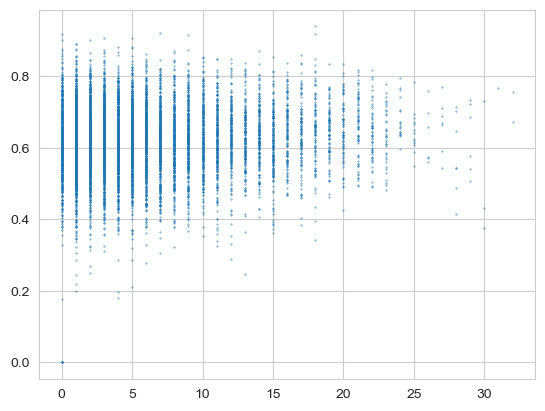

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                context   R-squared (uncentered):                   0.549
Model:                            OLS   Adj. R-squared (uncentered):              0.549
Method:                 Least Squares   F-statistic:                          1.217e+04
Date:                Fri, 08 Mar 2024   Prob (F-statistic):                        0.00
Time:                        14:42:59   Log-Likelihood:                         -5551.9
No. Observations:               10000   AIC:                                  1.111e+04
Df Residuals:                    9999   BIC:                                  1.111e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
year           0.0575      0.001    110.330      0.000       0.056       0.059
==============================================================================
Omnibus:                     1604.767   Durbin-Watson:                   1.137
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2553.190
Skew:                          -1.113   Prob(JB):                         0.00
Kurtosis:                       4.084   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [560]:
plt.scatter(df_pw_csp["year"], df_pw_csp["context"], s=0.1)
plt.show()

df_op = df_pw_csp
y = df_op['context']
X_cols = ['year']
#X = sm.add_constant(df_op[X_cols])
X = df_op[X_cols]

lm2 = sm.OLS(y, X).fit()
lm2.summary()

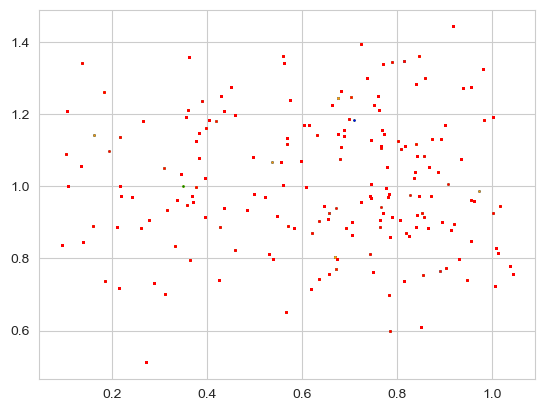

In [552]:
col = ['y', 'green', 'blue', 'orange', 'red']
for i in range(5):
    y_p = 25 - 5 * i
    df_op = df_pw_csp[df_pw_csp['year'] <= y_p]
    plt.scatter(df_op["structure"], df_op["function"], s=0.5, c=col[i])
plt.show()

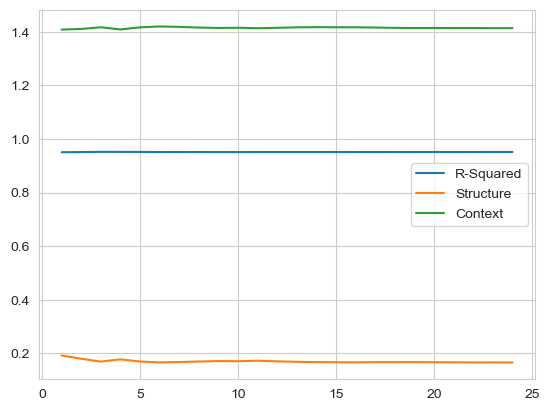

In [559]:
r_squared = []
const = []
para_0 = []
para_1 = []
for y_p in range(1, 25):
    df_op = df_pw_csp[df_pw_csp['year'] <= y_p]
    y = df_op['function']
    X_cols = ['structure', 'context']
    #X = sm.add_constant(df_op[X_cols])
    X = df_op[X_cols]

    lm2 = sm.OLS(y, X).fit()
    r_squared.append(lm2.rsquared_adj)
    #const.append(lm2.params.iloc[0])
    para_0.append(lm2.params.iloc[0])
    para_1.append(lm2.params.iloc[1])

plt.plot(range(1, 25), r_squared, label='R-Squared')
plt.plot(range(1, 25), para_0, label='Structure')
plt.plot(range(1, 25), para_1, label='Context')
plt.legend()
plt.show()

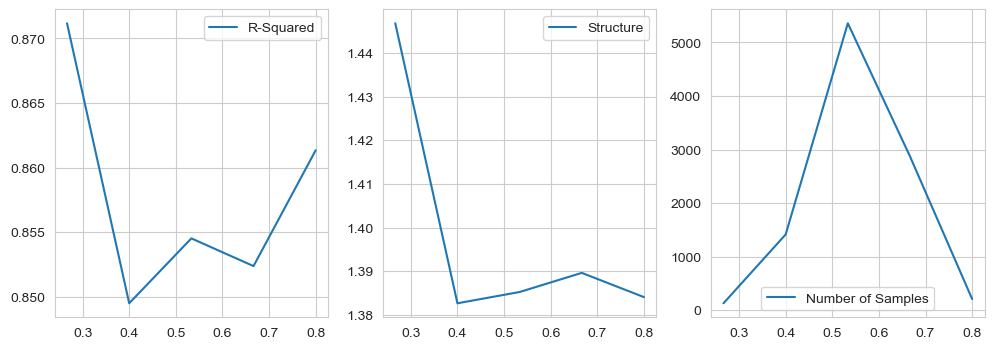

In [557]:
r_squared = []
const = []
para_0 = []
thre = np.linspace(0.0, 1.2, num=10)
thresh = []
num = []

for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw_csp[(df_pw_csp['context'] >= thre[i]) & (df_pw_csp['context'] < thre[i + 1])]
    y = df_op['function']
    if len(y) < 50:
        continue

    '''plt.scatter(df_op['structure'], df_op['function'])
    plt.show()'''

    X_cols = ['structure']
    #X = sm.add_constant(df_op[X_cols])
    X = df_op[X_cols]

    lm2 = sm.OLS(y, X).fit()
    thresh.append(y_p)
    num.append(len(y))
    r_squared.append(lm2.rsquared_adj)
    #const.append(lm2.params.iloc[0])
    para_0.append(lm2.params.iloc[0])

fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1, 3, 1)
ax1.plot(thresh, r_squared, label='R-Squared')
ax1.legend()
ax2 = plt.subplot(1, 3, 2)
ax2.plot(thresh, para_0, label='Structure')
ax2.legend()
ax3 = plt.subplot(1, 3, 3)
ax3.plot(thresh, num, label='Number of Samples')
ax3.legend()
plt.show()

In [486]:
y = df_pw_c['function']
X_cols = ['structure', 'context']
X = sm.add_constant(df_pw_c[X_cols])

lm2 = sm.OLS(y, X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               function   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1693
Date:                Thu, 07 Mar 2024   Prob (F-statistic):              0.844
Time:                        23:57:29   Log-Likelihood:                 2737.2
No. Observations:               10000   AIC:                            -5468.
Df Residuals:                    9997   BIC:                            -5447.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9977      0.005    193.807      0.000       0.988       1.008
structure      0.0042      0.007      0.581      0.561      -0.010       0.018
context        0.0013      0.024      0.055      0.956      -0.046       0.048
==============================================================================
Omnibus:                       13.943   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               12.187
Skew:                          -0.029   Prob(JB):                      0.00226
Kurtosis:                       2.839   Cond. No.                         15.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [372]:
random.seed(0)
df_a = df_p2c.sample(1000)['pmid']
random.seed(1)
df_b = df_p2c.sample(1000)['pmid']

k_a = []
k_b = []
for i in df_a:
    for j in df_b:
        if i != j:
            k_a.append(i)
            k_b.append(j)

random.seed(42)
df_c = pd.DataFrame({
    'A': k_a,
    'B': k_b
}).sample(40000, ignore_index=True)

df_c.to_csv("./df_c.csv", index=False)

text_df = pd.read_csv("./embedded_Pmid_para.csv")
text_df["ada_embedding"] = text_df["ada_embedding"].apply(lambda x: [float(i) for i in x[1:-1].split(',')])

clusterer = sklearn.cluster.KMeans(n_clusters=742, random_state=10, n_init='auto')
cluster_labels = clusterer.fit_predict(np.array(list(text_df["ada_embedding"])))
text_df['ada_cluster'] = cluster_labels
sklearn.metrics.adjusted_rand_score(text_df['cluster'], text_df['ada_cluster'])

#0.12168072478023129

In [304]:
smile_df = pd.read_csv("./Chem_sm_embd.csv")
smile_df = smile_df[smile_df["iupac"].apply(lambda x: x not in abn_set)]
smile_df['embd'] = smile_df['embd'].apply(lambda x: [float(i) for i in x[1:-1].split(',')])

ntwk_df = pd.read_csv("./graph_embedding_p.csv")
func_embd_s = []
for idx, row in smile_df.iterrows():
    func_embd = \
        ntwk_df[ntwk_df['name'] == row['iupac']]['embedding'].apply(lambda x: [float(i) for i in x[1:-1].split()]).iloc[
            0]
    if not func_embd:
        break
    func_embd_s.append(func_embd)
smile_df['func_embd'] = func_embd_s

In [381]:
%%time
struc_embd = []
func_embd = []
txt_embd = []
cluster = []
year = []

for A, B in tqdm([(df_c.iloc[i, 0], df_c.iloc[i, 1]) for i in range(len(df_c))]):
    p2c = df_p2c[df_p2c['pmid'] == A]
    smile_sp = smile_df[smile_df['iupac'].isin(set(p2c["chem_name"]))]
    struc_a = np.mean(np.array(list(smile_sp['embd'])), axis=0).round(3)
    func_a = np.mean(np.array(list(smile_sp['func_embd'])), axis=0).round(3)

    txt_a, cla, ya = text_df[text_df['pmid'] == int(A)].iloc[0][['ada_embedding', 'cluster', 'year']]

    p2c = df_p2c[df_p2c['pmid'] == B]
    smile_sp = smile_df[smile_df['iupac'].isin(set(p2c["chem_name"]))]
    struc_b = np.mean(np.array(list(smile_sp['embd'])), axis=0).round(3)
    func_b = np.mean(np.array(list(smile_sp['func_embd'])), axis=0).round(3)

    txt_b, clb, yb = text_df[text_df['pmid'] == int(B)].iloc[0][['ada_embedding', 'cluster', 'year']]

    struc_embd.append(distance.cosine(struc_a, struc_b))
    func_embd.append(distance.cosine(func_a, func_b))
    txt_embd.append(distance.cosine(txt_a, txt_b))
    cluster.append(cla == clb)
    year.append(np.abs(ya - yb))

df_pw = pd.DataFrame({
    "A": list(df_c["A"]),
    "B": list(df_c["B"]),
    "structure": struc_embd,
    "function": func_embd,
    "context": txt_embd,
    "cluster": [int(i) for i in cluster],
    'year': year
})

df_pw.to_csv('pw_cor.csv', index=False)

100%|██████████| 40000/40000 [16:18<00:00, 40.87it/s]


CPU times: user 15min 50s, sys: 20.1 s, total: 16min 10s
Wall time: 16min 19s


In [621]:
len(df_pw)

40000

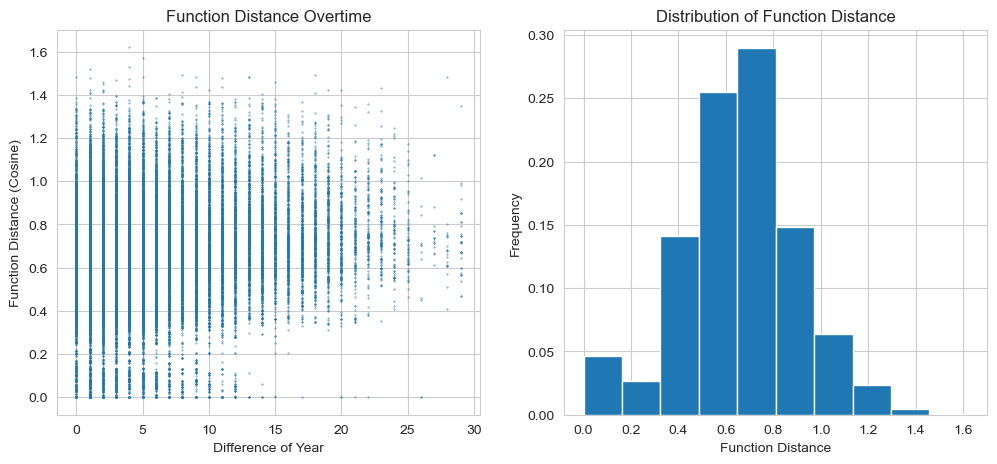

In [630]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Function Distance Overtime")
ax1.scatter(df_pw["year"], df_pw["function"], s=0.1)
ax1.set_xlabel("Difference of Year")
ax1.set_ylabel("Function Distance (Cosine)")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Distribution of Function Distance")
ax2.hist(df_pw["function"], weights=[1 / len(df_pw)] * len(df_pw))
ax2.set_xlabel("Function Distance")
ax2.set_ylabel("Frequency")
plt.show()

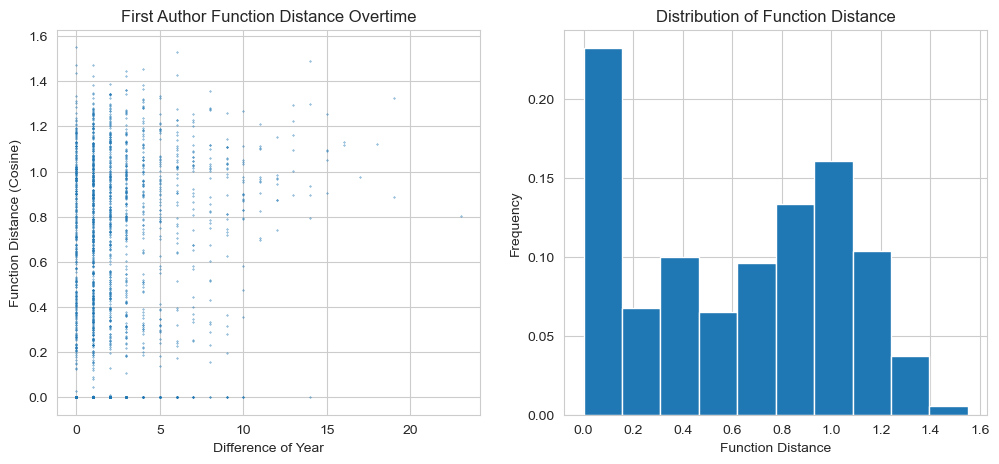

In [631]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("First Author Function Distance Overtime")
ax1.scatter(df_pw_f["year"], df_pw_f["function"], s=0.1)
ax1.set_xlabel("Difference of Year")
ax1.set_ylabel("Function Distance (Cosine)")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Distribution of Function Distance")
ax2.hist(df_pw_f["function"], weights=[1 / len(df_pw_f)] * len(df_pw_f))
ax2.set_xlabel("Function Distance")
ax2.set_ylabel("Frequency")
plt.show()

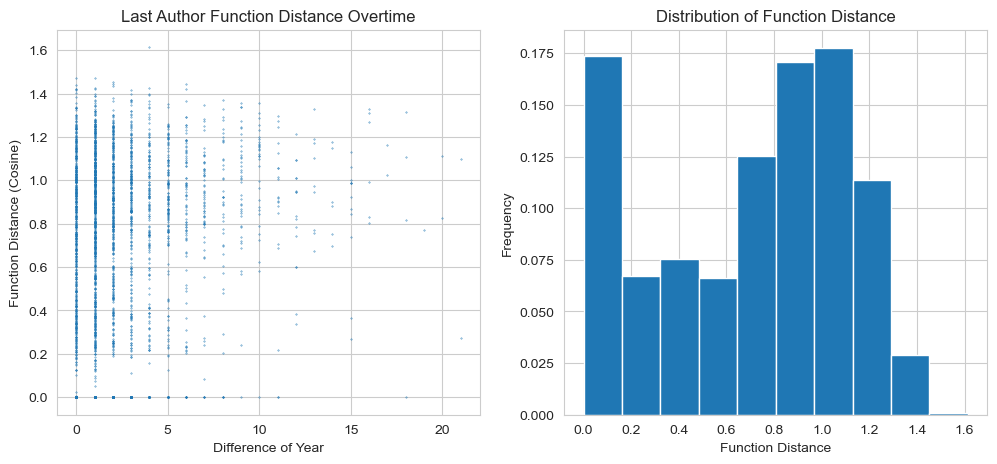

In [632]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Last Author Function Distance Overtime")
ax1.scatter(df_pw_l["year"], df_pw_l["function"], s=0.1)
ax1.set_xlabel("Difference of Year")
ax1.set_ylabel("Function Distance (Cosine)")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Distribution of Function Distance")
ax2.hist(df_pw_l["function"], weights=[1 / len(df_pw_l)] * len(df_pw_l))
ax2.set_xlabel("Function Distance")
ax2.set_ylabel("Frequency")
plt.show()

In [386]:
df_op = df_pw
y = df_op['context']
X_cols = ['year', 'cluster']
X = sm.add_constant(df_op[X_cols])

lm2 = sm.OLS(y, X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                context   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     552.4
Date:                Thu, 07 Mar 2024   Prob (F-statistic):          2.23e-237
Time:                        22:27:36   Log-Likelihood:                 39210.
No. Observations:               40000   AIC:                        -7.841e+04
Df Residuals:                   39997   BIC:                        -7.839e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6021      0.001    878.527      0.000       0.601       0.603
year           0.0019   8.59e-05     22.392      0.000       0.002       0.002
cluster       -0.0899      0.004    -24.023      0.000      -0.097      -0.083
==============================================================================
Omnibus:                      621.555   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              735.368
Skew:                          -0.250   Prob(JB):                    2.07e-160
Kurtosis:                       3.438   Cond. No.                         65.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

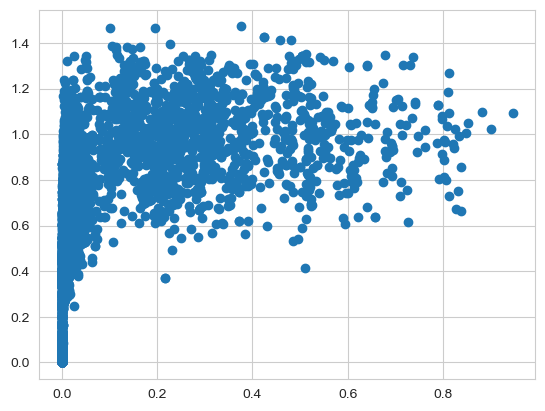

In [313]:
plt.scatter(df_pw["structure"], df_pw["function"])

In [326]:
df_pw.year.min()

0

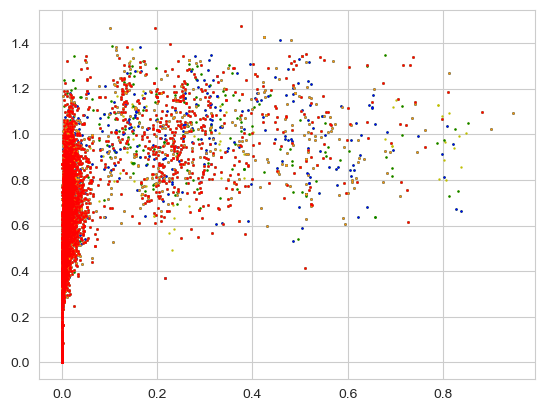

In [342]:
col = ['y', 'green', 'blue', 'orange', 'red']
for i in range(5):
    y_p = 25 - 5 * i
    df_op = df_pw[df_pw['year'] <= y_p]
    plt.scatter(df_op["structure"], df_op["function"], s=0.5, c=col[i])
plt.show()

In [ ]:
plt.contour(X, Y, Z, levels=10, cmap='viridis')  # levels指定等高线的数量
plt.colorbar(label='Z values')  # 添加颜色条
plt.title('Contour Plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

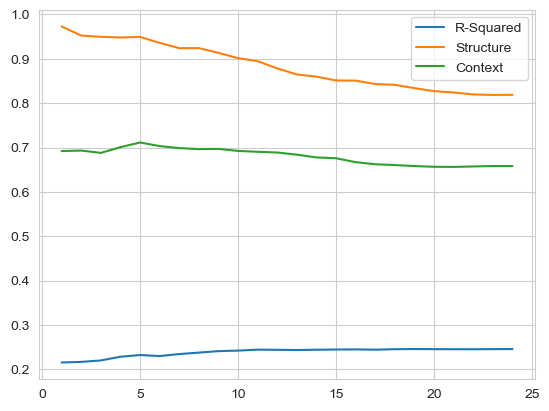

In [449]:
r_squared = []
const = []
para_0 = []
para_1 = []
for y_p in range(1, 25):
    df_op = df_pw[df_pw['year'] <= y_p]
    y = df_op['function']
    X_cols = ['structure', 'context']
    X = sm.add_constant(df_op[X_cols])

    lm2 = sm.OLS(y, X).fit()
    r_squared.append(lm2.rsquared_adj)
    const.append(lm2.params.iloc[0])
    para_0.append(lm2.params.iloc[1])
    para_1.append(lm2.params.iloc[2])

plt.plot(range(1, 25), r_squared, label='R-Squared')
plt.plot(range(1, 25), para_0, label='Structure')
plt.plot(range(1, 25), para_1, label='Context')
plt.legend()
plt.show()

r_squared = []
const = []
para_0 = []
thre = np.linspace(0.1, 1, num=20)

for y_p in thre:
    df_op = df_pw[df_pw['context'] <= y_p]
    y = df_op['function']
    X_cols = ['structure']
    X = sm.add_constant(df_op[X_cols])

    lm2 = sm.OLS(y, X).fit()
    r_squared.append(lm2.rsquared_adj)
    const.append(lm2.params.iloc[0])
    para_0.append(lm2.params.iloc[1])

plt.plot(thre, r_squared, label='R-Squared')
plt.plot(thre, para_0, label='Structure')
plt.legend()
plt.show()

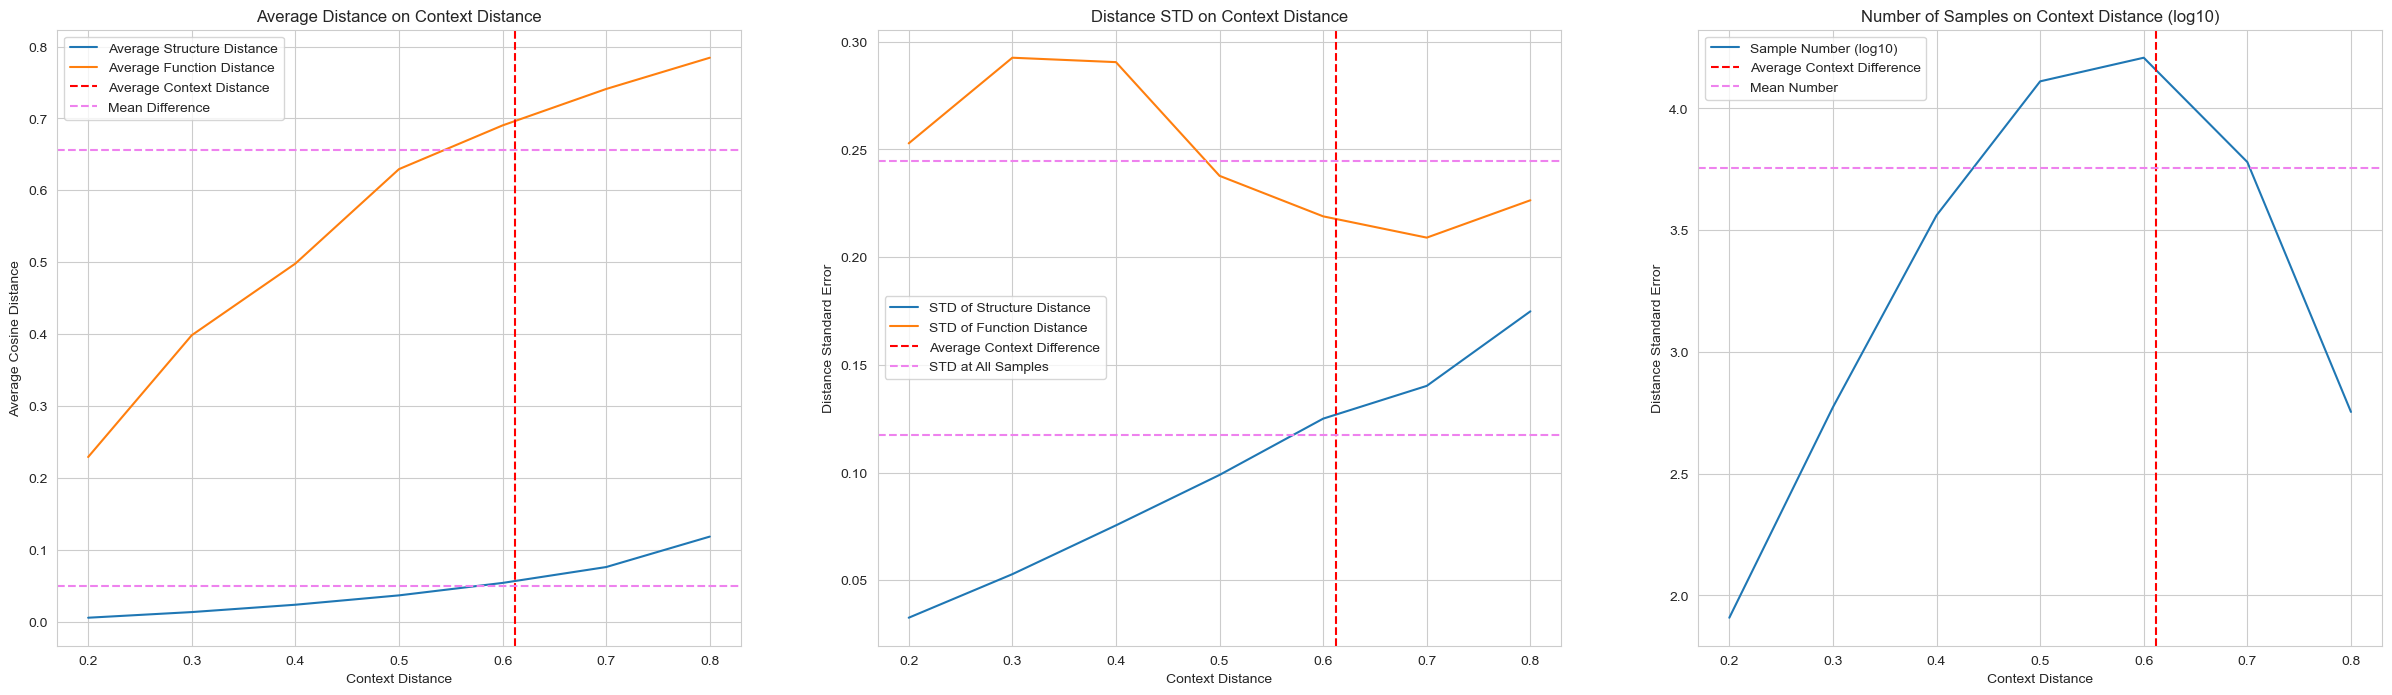

In [634]:
func_mean = []
struc_mean = []

func_std = []
struc_std = []

thre = np.linspace(0.1, 1.2, num=12)
t_list = []
num_list = []

for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw[(df_pw['context'] >= thre[i]) & (df_pw['context'] < thre[i + 1])]
    #df_op = df_pw[df_pw['context'] < thre[i + 1]]

    y = df_op['function']
    x = df_op['structure']

    if len(y) < 50:
        continue

    t_list.append(y_p)
    num_list.append(len(y))
    func_mean.append(y.mean())
    func_std.append(y.std())

    struc_mean.append(x.mean())
    struc_std.append(x.std())

avg_struc = df_pw["structure"].mean()
std_struc = df_pw["structure"].std()
avg_func = df_pw["function"].mean()
std_func = df_pw["function"].std()
avg_text = df_pw["context"].mean()
std_text = df_pw["context"].std()
avg_num = np.log10(np.array(num_list).mean())

fig = plt.figure(figsize=(30, 8))
ax1 = plt.subplot(1, 3, 1)
ax1.set_title("Average Distance on Context Distance")
ax1.set_ylabel("Average Cosine Distance")
ax1.set_xlabel("Context Distance")
ax1.plot(t_list, struc_mean, label='Average Structure Distance')
ax1.plot(t_list, func_mean, label='Average Function Distance')
ax1.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Distance')
ax1.axhline(y=avg_struc, color='violet', linestyle='--', label='Mean Difference')
ax1.axhline(y=avg_func, color='violet', linestyle='--')
ax1.legend()

ax2 = plt.subplot(1, 3, 2)
ax2.set_title("Distance STD on Context Distance")
ax2.set_ylabel("Distance Standard Error")
ax2.set_xlabel("Context Distance")
ax2.plot(t_list, struc_std, label='STD of Structure Distance')
ax2.plot(t_list, func_std, label='STD of Function Distance')
ax2.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Difference')
ax2.axhline(y=std_struc, color='violet', linestyle='--', label='STD at All Samples')
ax2.axhline(y=std_func, color='violet', linestyle='--')
ax2.legend()

ax3 = plt.subplot(1, 3, 3)
ax3.set_title("Number of Samples on Context Distance (log10)")
ax3.set_ylabel("Distance Standard Error")
ax3.set_xlabel("Context Distance")
ax3.plot(t_list, np.log10(np.array(num_list)), label="Sample Number (log10)")
ax3.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Difference')
ax3.axhline(y=avg_num, color='violet', linestyle='--', label='Mean Number')
ax3.legend()

plt.show()

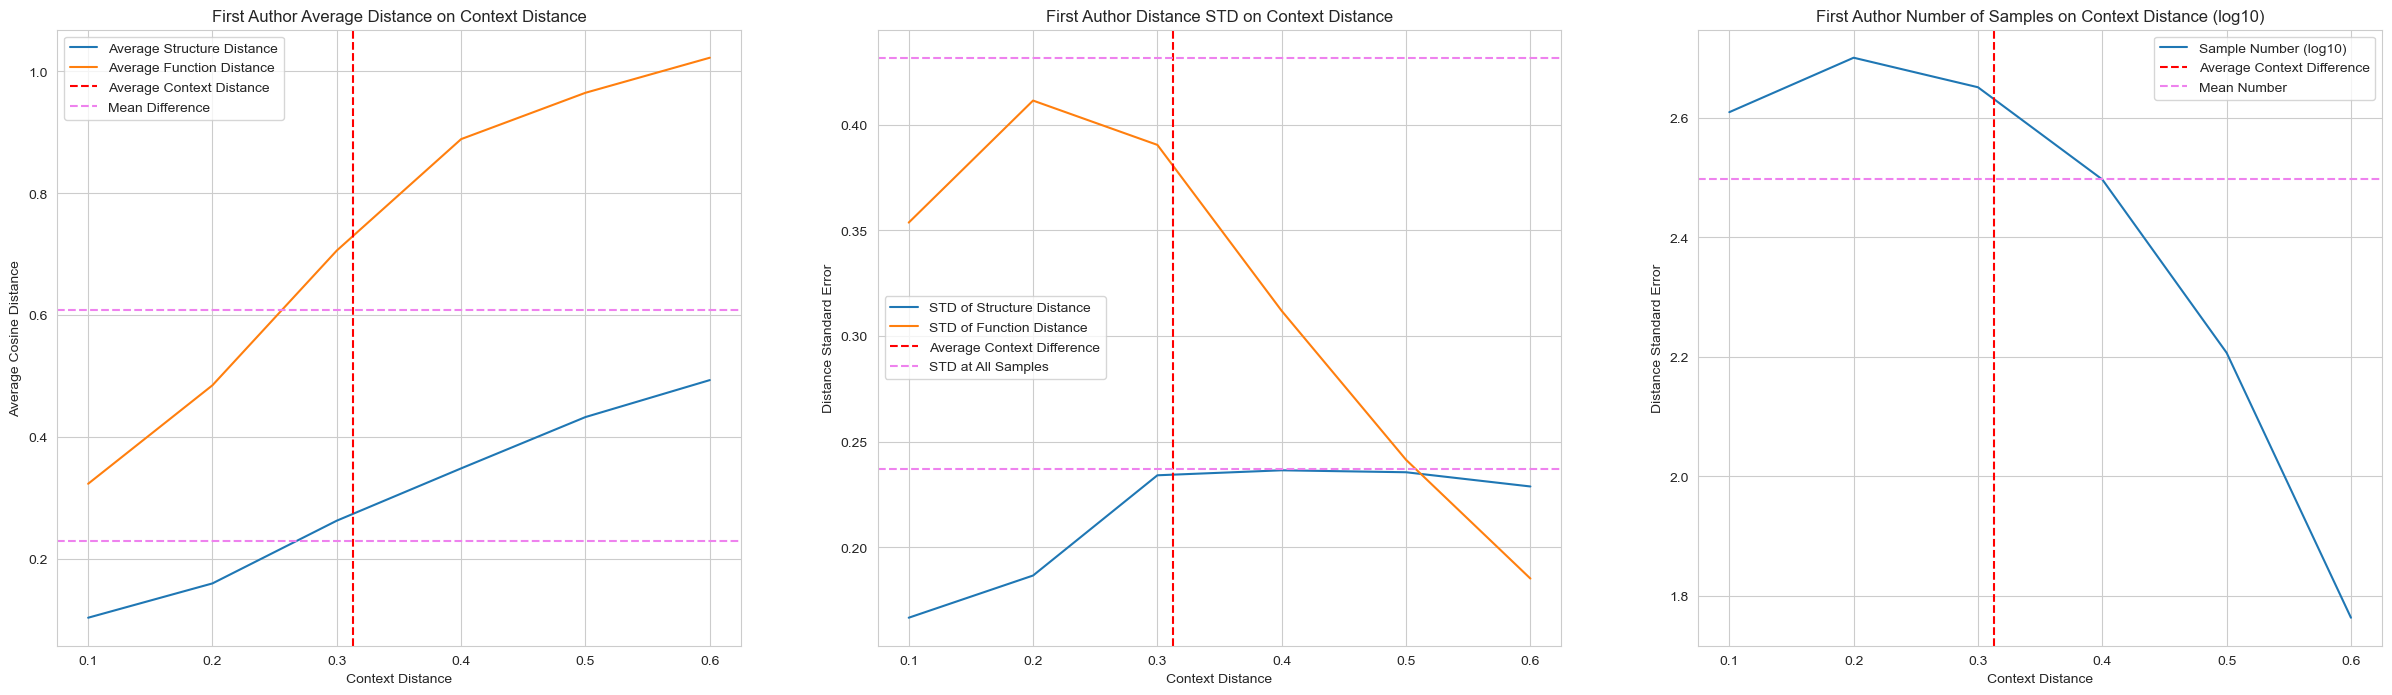

In [637]:
func_mean = []
struc_mean = []

func_std = []
struc_std = []

thre = np.linspace(0.1, 1.2, num=12)
t_list = []
num_list = []

for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw_f[(df_pw_f['context'] >= thre[i]) & (df_pw_f['context'] < thre[i + 1])]
    #df_op = df_pw[df_pw['context'] < thre[i + 1]]

    y = df_op['function']
    x = df_op['structure']

    if len(y) < 50:
        continue

    t_list.append(y_p)
    num_list.append(len(y))
    func_mean.append(y.mean())
    func_std.append(y.std())

    struc_mean.append(x.mean())
    struc_std.append(x.std())

avg_struc = df_pw_f["structure"].mean()
std_struc = df_pw_f["structure"].std()
avg_func = df_pw_f["function"].mean()
std_func = df_pw_f["function"].std()
avg_text = df_pw_f["context"].mean()
std_text = df_pw_f["context"].std()
avg_num = np.log10(np.array(num_list).mean())

fig = plt.figure(figsize=(30, 8))
ax1 = plt.subplot(1, 3, 1)
ax1.set_title("First Author Average Distance on Context Distance")
ax1.set_ylabel("Average Cosine Distance")
ax1.set_xlabel("Context Distance")
ax1.plot(t_list, struc_mean, label='Average Structure Distance')
ax1.plot(t_list, func_mean, label='Average Function Distance')
ax1.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Distance')
ax1.axhline(y=avg_struc, color='violet', linestyle='--', label='Mean Difference')
ax1.axhline(y=avg_func, color='violet', linestyle='--')
ax1.legend()

ax2 = plt.subplot(1, 3, 2)
ax2.set_title("First Author Distance STD on Context Distance")
ax2.set_ylabel("Distance Standard Error")
ax2.set_xlabel("Context Distance")
ax2.plot(t_list, struc_std, label='STD of Structure Distance')
ax2.plot(t_list, func_std, label='STD of Function Distance')
ax2.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Difference')
ax2.axhline(y=std_struc, color='violet', linestyle='--', label='STD at All Samples')
ax2.axhline(y=std_func, color='violet', linestyle='--')
ax2.legend()

ax3 = plt.subplot(1, 3, 3)
ax3.set_title("First Author Number of Samples on Context Distance (log10)")
ax3.set_ylabel("Distance Standard Error")
ax3.set_xlabel("Context Distance")
ax3.plot(t_list, np.log10(np.array(num_list)), label="Sample Number (log10)")
ax3.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Difference')
ax3.axhline(y=avg_num, color='violet', linestyle='--', label='Mean Number')
ax3.legend()

plt.show()

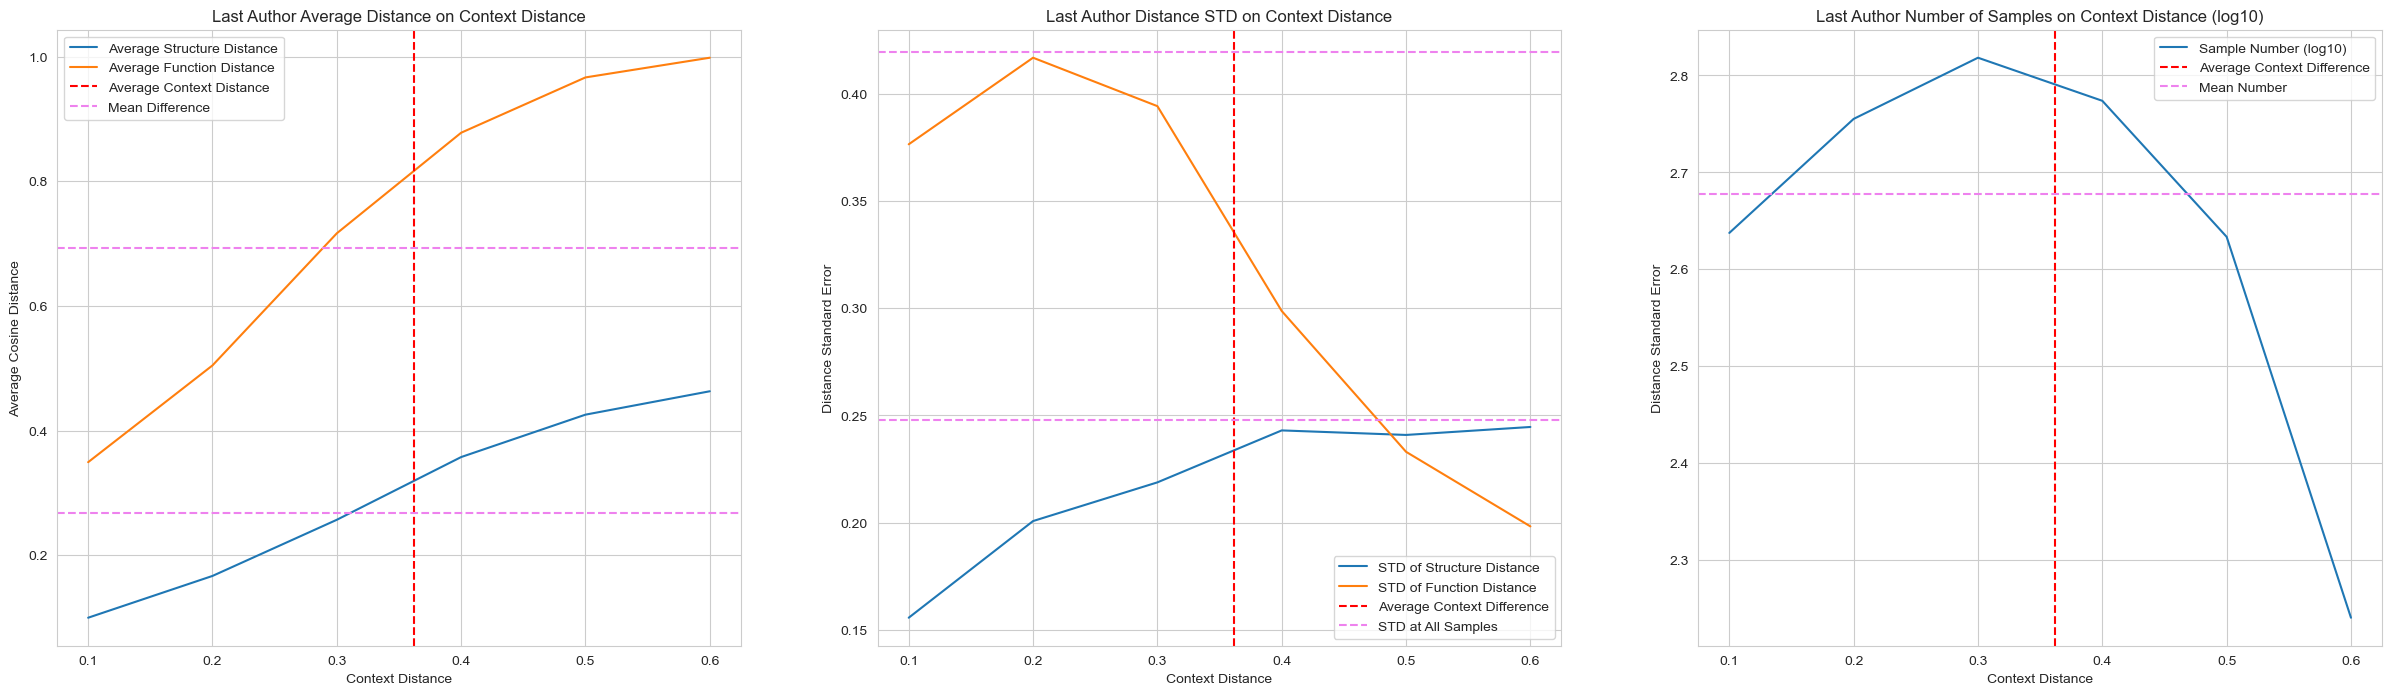

In [638]:
func_mean = []
struc_mean = []

func_std = []
struc_std = []

thre = np.linspace(0.1, 1.2, num=12)
t_list = []
num_list = []

for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw_l[(df_pw_l['context'] >= thre[i]) & (df_pw_l['context'] < thre[i + 1])]
    #df_op = df_pw[df_pw['context'] < thre[i + 1]]

    y = df_op['function']
    x = df_op['structure']

    if len(y) < 50:
        continue

    t_list.append(y_p)
    num_list.append(len(y))
    func_mean.append(y.mean())
    func_std.append(y.std())

    struc_mean.append(x.mean())
    struc_std.append(x.std())

avg_struc = df_pw_l["structure"].mean()
std_struc = df_pw_l["structure"].std()
avg_func = df_pw_l["function"].mean()
std_func = df_pw_l["function"].std()
avg_text = df_pw_l["context"].mean()
std_text = df_pw_l["context"].std()
avg_num = np.log10(np.array(num_list).mean())

fig = plt.figure(figsize=(30, 8))
ax1 = plt.subplot(1, 3, 1)
ax1.set_title("Last Author Average Distance on Context Distance")
ax1.set_ylabel("Average Cosine Distance")
ax1.set_xlabel("Context Distance")
ax1.plot(t_list, struc_mean, label='Average Structure Distance')
ax1.plot(t_list, func_mean, label='Average Function Distance')
ax1.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Distance')
ax1.axhline(y=avg_struc, color='violet', linestyle='--', label='Mean Difference')
ax1.axhline(y=avg_func, color='violet', linestyle='--')
ax1.legend()

ax2 = plt.subplot(1, 3, 2)
ax2.set_title("Last Author Distance STD on Context Distance")
ax2.set_ylabel("Distance Standard Error")
ax2.set_xlabel("Context Distance")
ax2.plot(t_list, struc_std, label='STD of Structure Distance')
ax2.plot(t_list, func_std, label='STD of Function Distance')
ax2.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Difference')
ax2.axhline(y=std_struc, color='violet', linestyle='--', label='STD at All Samples')
ax2.axhline(y=std_func, color='violet', linestyle='--')
ax2.legend()

ax3 = plt.subplot(1, 3, 3)
ax3.set_title("Last Author Number of Samples on Context Distance (log10)")
ax3.set_ylabel("Distance Standard Error")
ax3.set_xlabel("Context Distance")
ax3.plot(t_list, np.log10(np.array(num_list)), label="Sample Number (log10)")
ax3.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Difference')
ax3.axhline(y=avg_num, color='violet', linestyle='--', label='Mean Number')
ax3.legend()

plt.show()

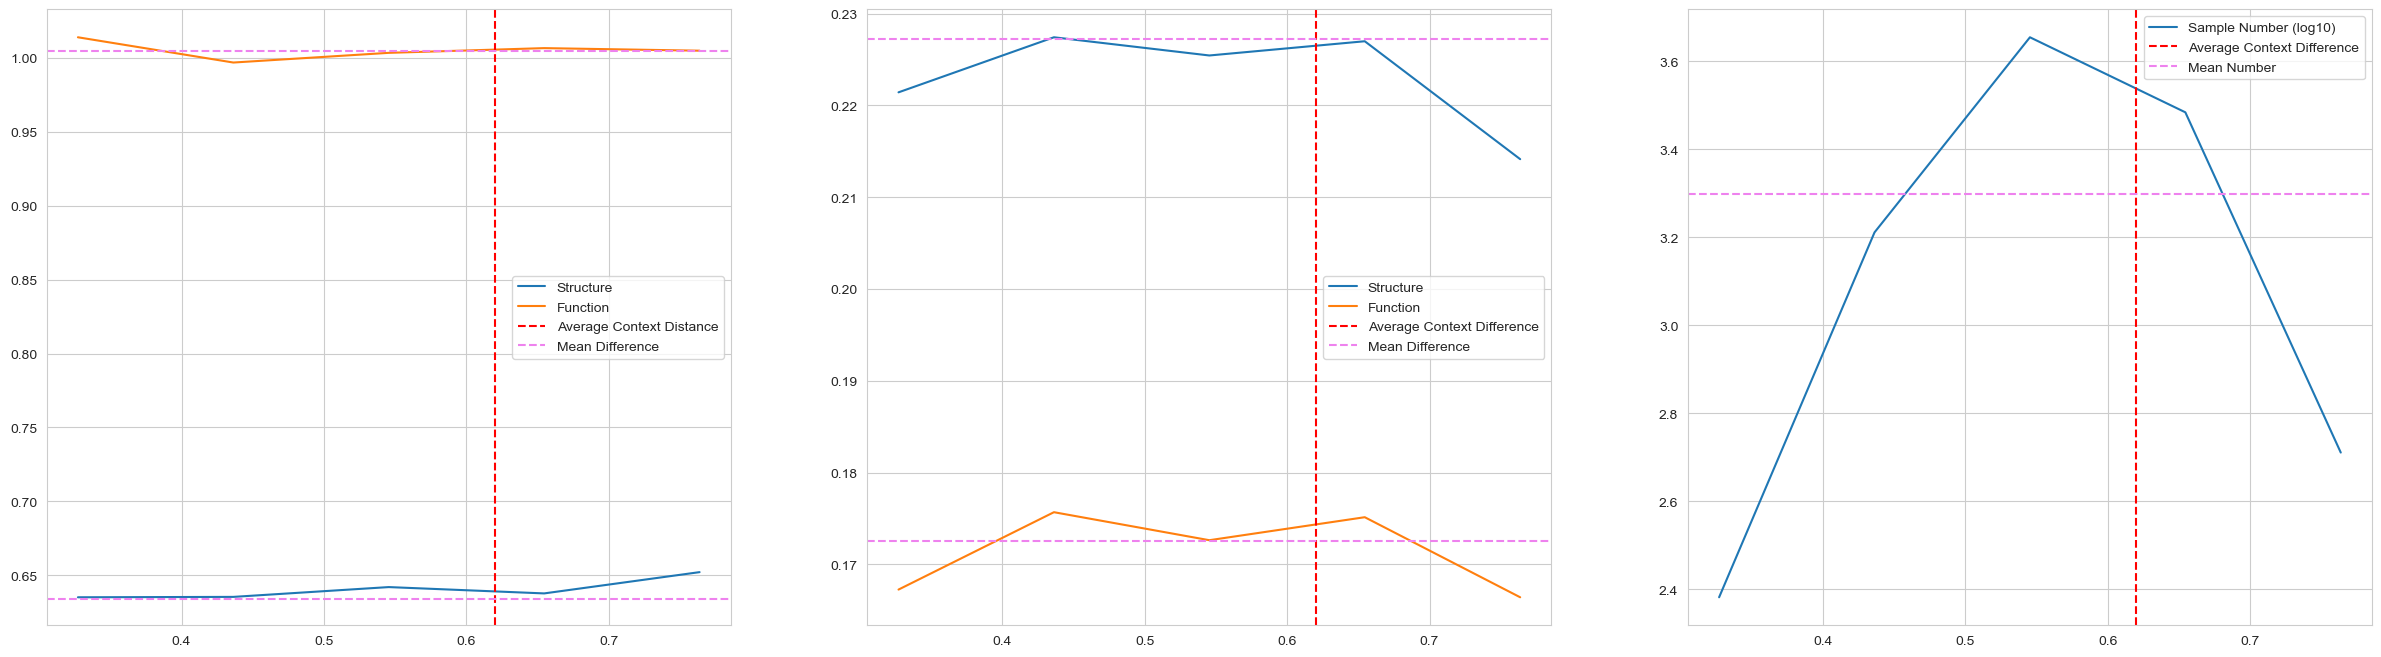

In [561]:
func_mean = []
struc_mean = []

func_std = []
struc_std = []

thre = np.linspace(0., 1.2, num=12)
t_list = []
num_list = []

for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw_csp[(df_pw_csp['context'] >= thre[i]) & (df_pw_csp['context'] < thre[i + 1])]
    #df_op = df_pw[df_pw['context'] < thre[i + 1]]

    y = df_op['function']
    x = df_op['structure']

    if len(y) < 50:
        continue

    t_list.append(y_p)
    num_list.append(len(y))
    func_mean.append(y.mean())
    func_std.append(y.std())

    struc_mean.append(x.mean())
    struc_std.append(x.std())

avg_struc = df_pw_c["structure"].mean()
std_struc = df_pw_c["structure"].std()
avg_func = df_pw_c["function"].mean()
std_func = df_pw_c["function"].std()
avg_text = df_pw_c["context"].mean()
std_text = df_pw_c["context"].std()
avg_num = np.log10(np.array(num_list).mean())

fig = plt.figure(figsize=(30, 8))
ax1 = plt.subplot(1, 3, 1)
ax1.plot(t_list, struc_mean, label='Structure')
ax1.plot(t_list, func_mean, label='Function')
ax1.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Distance')
ax1.axhline(y=avg_struc, color='violet', linestyle='--', label='Mean Difference')
ax1.axhline(y=avg_func, color='violet', linestyle='--')
ax1.legend()

ax2 = plt.subplot(1, 3, 2)
ax2.plot(t_list, struc_std, label='Structure')
ax2.plot(t_list, func_std, label='Function')
ax2.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Difference')
ax2.axhline(y=std_struc, color='violet', linestyle='--', label='Mean Difference')
ax2.axhline(y=std_func, color='violet', linestyle='--')
ax2.legend()

ax3 = plt.subplot(1, 3, 3)
ax3.plot(t_list, np.log10(np.array(num_list)), label="Sample Number (log10)")
ax3.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Difference')
ax3.axhline(y=avg_num, color='violet', linestyle='--', label='Mean Number')
ax3.legend()

plt.show()

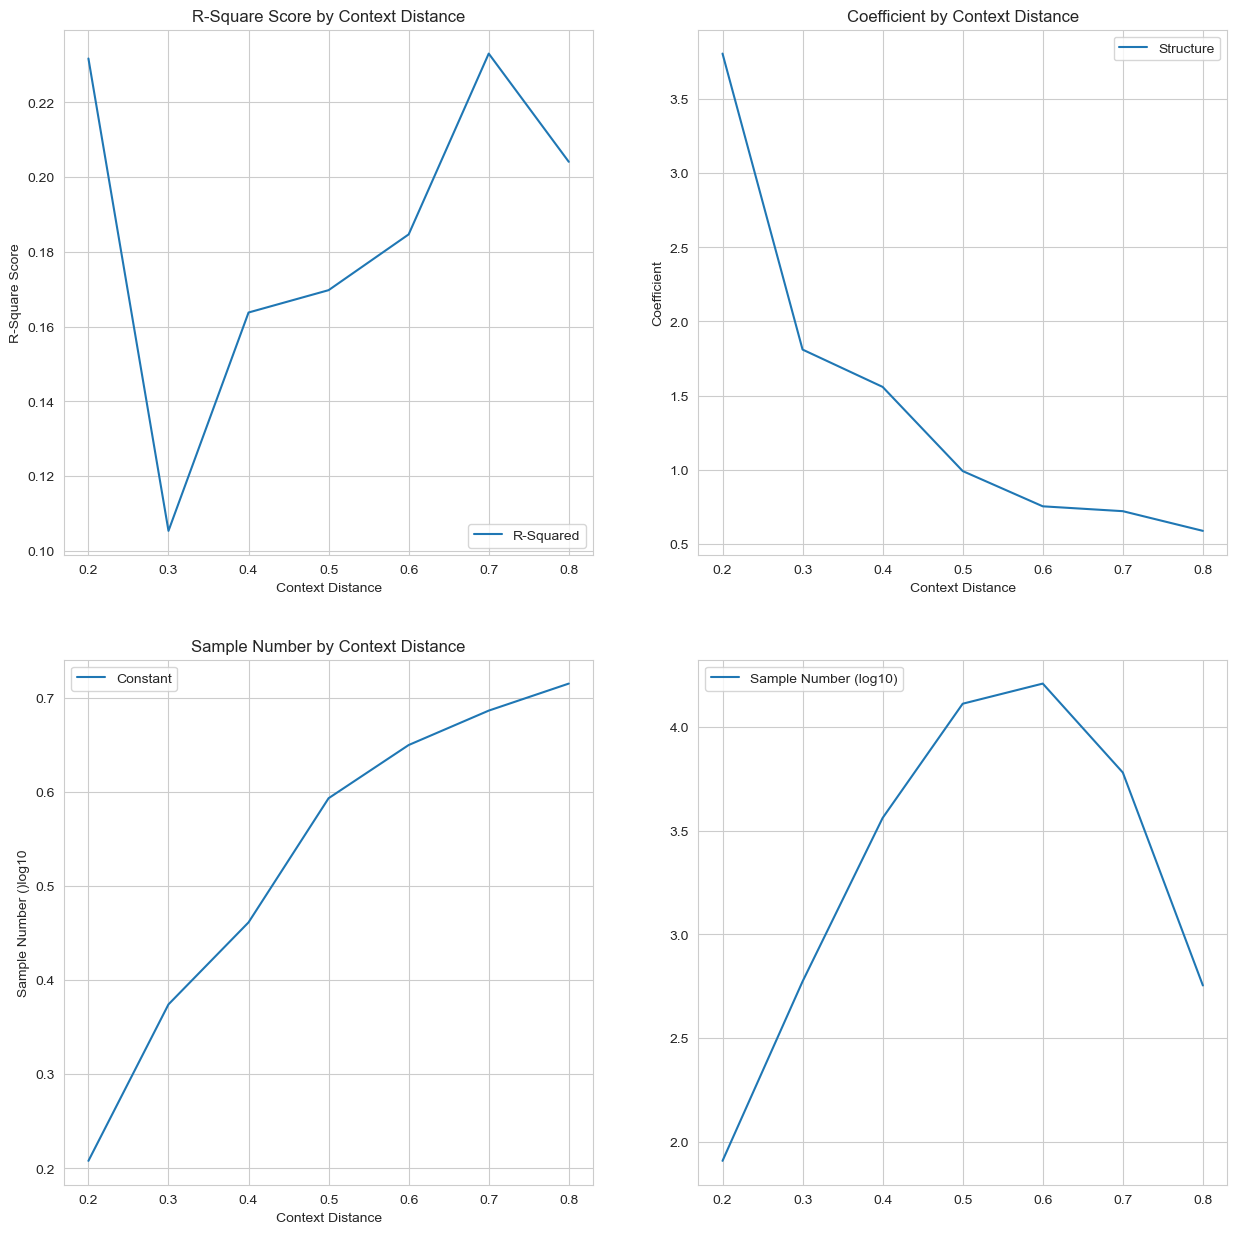

In [641]:
r_squared = []
const = []
para_0 = []
thre = np.linspace(0.1, 1.2, num=12)
t_list = []
num = []

for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw[(df_pw['context'] >= thre[i]) & (df_pw['context'] < thre[i + 1])]
    y = df_op['function']

    if len(y) < 50:
        continue
    '''plt.scatter(df_op['structure'], df_op['function'], label=y_p)
    plt.legend()
    plt.show()'''
    X_cols = ['structure']
    X = sm.add_constant(df_op[X_cols])
    #X = df_op[X_cols]

    lm2 = sm.OLS(y, X).fit()
    t_list.append(y_p)
    num.append(len(y))
    r_squared.append(lm2.rsquared_adj)
    const.append(lm2.params.iloc[0])
    para_0.append(lm2.params.iloc[1])

fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot(2, 2, 1)
ax1.set_title("R-Square Score by Context Distance")
ax1.set_ylabel("R-Square Score")
ax1.set_xlabel("Context Distance")
ax1.plot(t_list, r_squared, label='R-Squared')
ax1.legend()
ax2 = plt.subplot(2, 2, 2)
ax2.set_title("Coefficient by Context Distance")
ax2.set_ylabel("Coefficient")
ax2.set_xlabel("Context Distance")
ax2.plot(t_list, para_0, label='Structure')
ax2.legend()
ax3 = plt.subplot(2, 2, 3)
ax3.set_title("Constant by Context Distance")
ax3.set_ylabel("Constant")
ax3.set_xlabel("Context Distance")
ax3.plot(t_list, const, label='Constant')
ax3.legend()
ax4 = plt.subplot(2, 2, 4)
ax3.set_title("Sample Number by Context Distance")
ax3.set_ylabel("Sample Number ()log10")
ax3.set_xlabel("Context Distance")
ax4.plot(t_list, np.log10(np.array(num)), label='Sample Number (log10)')
ax4.legend()
plt.show()

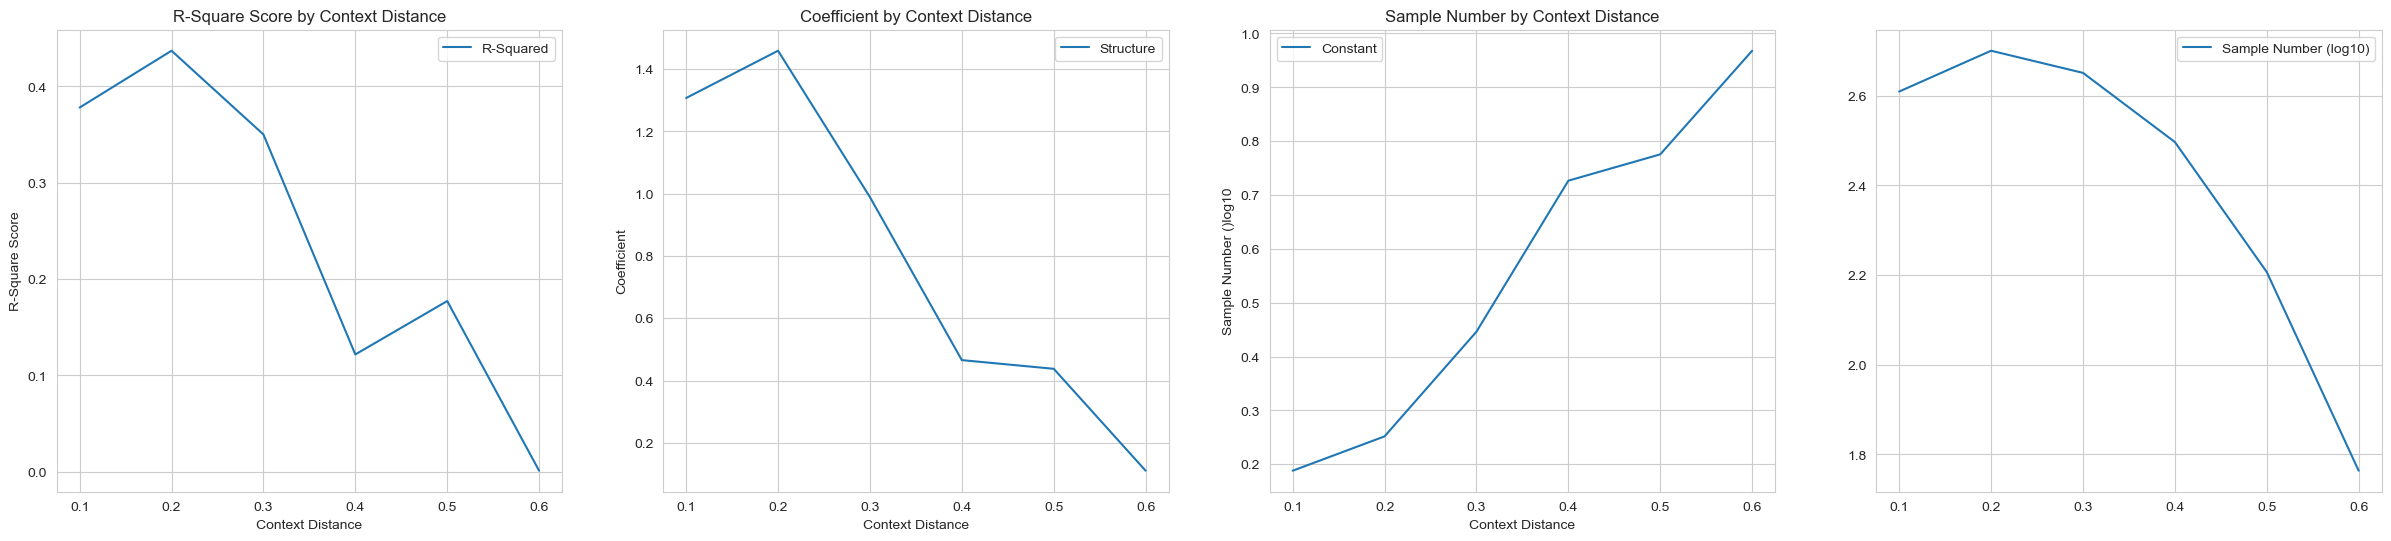

In [640]:
r_squared = []
const = []
para_0 = []
thre = np.linspace(0.1, 1.2, num=12)
t_list = []
num = []

for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw_f[(df_pw_f['context'] >= thre[i]) & (df_pw_f['context'] < thre[i + 1])]
    y = df_op['function']

    if len(y) < 50:
        continue
    '''plt.scatter(df_op['structure'], df_op['function'], label=y_p)
    plt.legend()
    plt.show()'''
    X_cols = ['structure']
    X = sm.add_constant(df_op[X_cols])
    #X = df_op[X_cols]

    lm2 = sm.OLS(y, X).fit()
    t_list.append(y_p)
    num.append(len(y))
    r_squared.append(lm2.rsquared_adj)
    const.append(lm2.params.iloc[0])
    para_0.append(lm2.params.iloc[1])

fig = plt.figure(figsize=(30, 6))
ax1 = plt.subplot(1, 4, 1)
ax1.set_title("R-Square Score by Context Distance")
ax1.set_ylabel("R-Square Score")
ax1.set_xlabel("Context Distance")
ax1.plot(t_list, r_squared, label='R-Squared')
ax1.legend()
ax2 = plt.subplot(1, 4, 2)
ax2.set_title("Coefficient by Context Distance")
ax2.set_ylabel("Coefficient")
ax2.set_xlabel("Context Distance")
ax2.plot(t_list, para_0, label='Structure')
ax2.legend()
ax3 = plt.subplot(1, 4, 3)
ax3.set_title("Constant by Context Distance")
ax3.set_ylabel("Constant")
ax3.set_xlabel("Context Distance")
ax3.plot(t_list, const, label='Constant')
ax3.legend()
ax4 = plt.subplot(1, 4, 4)
ax3.set_title("Sample Number by Context Distance")
ax3.set_ylabel("Sample Number ()log10")
ax3.set_xlabel("Context Distance")
ax4.plot(t_list, np.log10(np.array(num)), label='Sample Number (log10)')
ax4.legend()
plt.show()

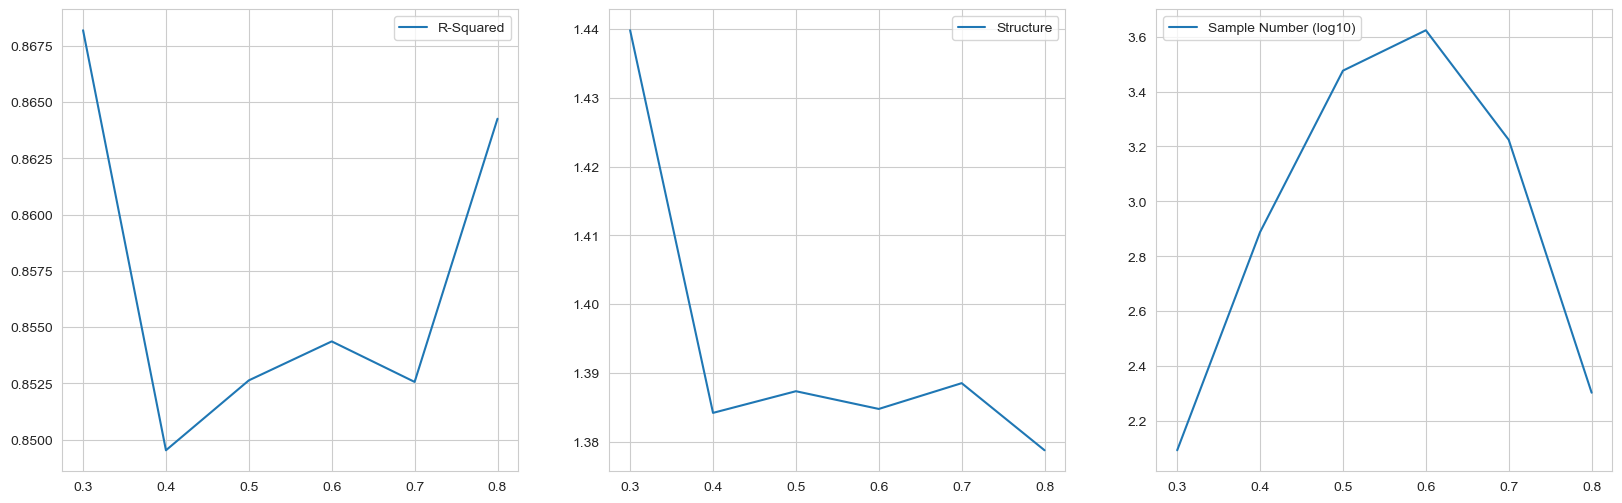

In [562]:
r_squared = []
const = []
para_0 = []
thre = np.linspace(0.1, 1.2, num=12)
t_list = []
num = []

for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw_csp[(df_pw_csp['context'] >= thre[i]) & (df_pw_csp['context'] < thre[i + 1])]
    y = df_op['function']

    if len(y) < 50:
        continue
    '''plt.scatter(df_op['structure'], df_op['function'], label=y_p)
    plt.legend()
    plt.show()'''
    X_cols = ['structure']
    #X = sm.add_constant(df_op[X_cols])
    X = df_op[X_cols]

    lm2 = sm.OLS(y, X).fit()
    t_list.append(y_p)
    num.append(len(y))
    r_squared.append(lm2.rsquared_adj)
    #const.append(lm2.params.iloc[0])
    para_0.append(lm2.params.iloc[0])

fig = plt.figure(figsize=(20, 6))
ax1 = plt.subplot(1, 3, 1)
ax1.plot(t_list, r_squared, label='R-Squared')
ax1.legend()
ax2 = plt.subplot(1, 3, 2)
ax2.plot(t_list, para_0, label='Structure')
ax2.legend()
ax3 = plt.subplot(1, 3, 3)
ax3.plot(t_list, np.log10(np.array(num)), label='Sample Number (log10)')
ax3.legend()
plt.show()

In [522]:
pd.DataFrame({
    'stamp': t_list,
    'num': num
})

,stamp,num
0,0.2,81
1,0.3,593
2,0.4,3637
3,0.5,12916
4,0.6,16148
5,0.7,6019
6,0.8,567


In [427]:
df_op = df_pw[(df_pw['context'] >= 0.20) & (df_pw['context'] < 0.3)]
y = df_op['function']
X_cols = ['structure']
X = sm.add_constant(df_op[X_cols])

lm2 = sm.OLS(y, X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               function   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     25.13
Date:                Thu, 07 Mar 2024   Prob (F-statistic):           3.21e-06
Time:                        22:45:58   Log-Likelihood:                 8.1448
No. Observations:                  81   AIC:                            -12.29
Df Residuals:                      79   BIC:                            -7.501
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2080      0.025      8.330      0.000       0.158       0.258
structure      3.8077      0.760      5.013      0.000       2.296       5.319
==============================================================================
Omnibus:                       14.452   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                8.578
Skew:                           0.636   Prob(JB):                       0.0137
Kurtosis:                       2.038   Cond. No.                         30.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

1.0

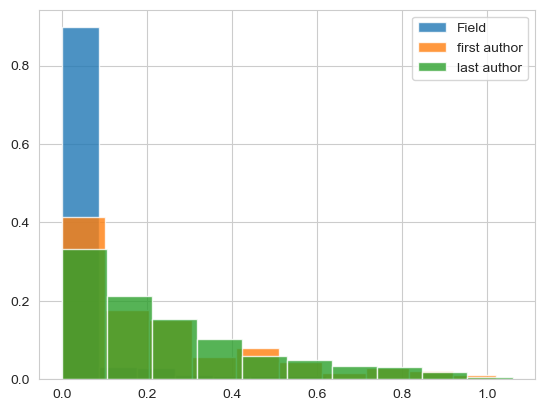

In [275]:
plt.hist(df_pw["structure"], weights=[1 / len(df_pw)] * len(df_pw), alpha=0.8, label="Field")
plt.hist(df_pw_f["structure"], weights=[1 / len(df_pw_f)] * len(df_pw_f), alpha=0.8, label="first author")
plt.hist(df_pw_l["structure"], weights=[1 / len(df_pw_l)] * len(df_pw_l), alpha=0.8, label='last author')
plt.legend()
plt.show()

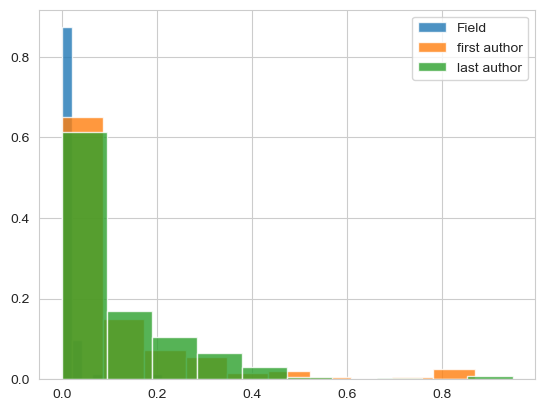

In [277]:
df_op = df_pw[df_pw['cluster'] == 1]
plt.hist(df_op["structure"], weights=[1 / len(df_op)] * len(df_op), alpha=0.8, label="Field")
df_op = df_pw_f[df_pw_f['cluster'] == 1]
plt.hist(df_op["structure"], weights=[1 / len(df_op)] * len(df_op), alpha=0.8, label="first author")
df_op = df_pw_l[df_pw_l['cluster'] == 1]
plt.hist(df_op["structure"], weights=[1 / len(df_op)] * len(df_op), alpha=0.8, label='last author')
plt.legend()
plt.show()

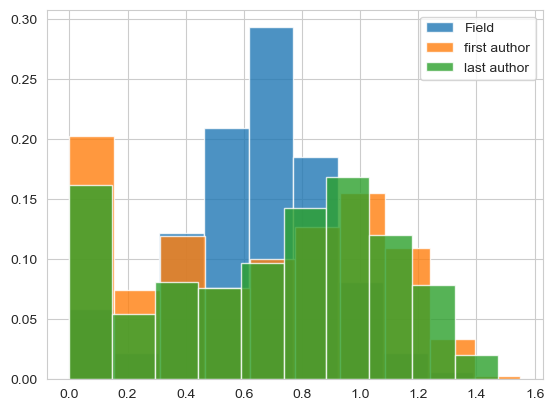

In [274]:
plt.hist(df_pw["function"], weights=[1 / len(df_pw)] * len(df_pw), alpha=0.8, label="Field")
plt.hist(df_pw_f["function"], weights=[1 / len(df_pw_f)] * len(df_pw_f), alpha=0.8, label="first author")
plt.hist(df_pw_l["function"], weights=[1 / len(df_pw_l)] * len(df_pw_l), alpha=0.8, label='last author')
plt.legend()
plt.show()

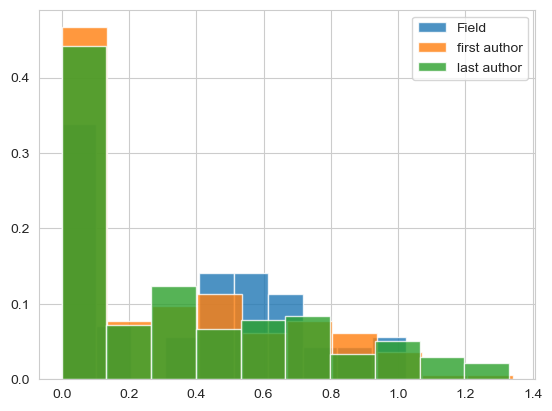

In [278]:
df_op = df_pw[df_pw['cluster'] == 1]
plt.hist(df_op["function"], weights=[1 / len(df_op)] * len(df_op), alpha=0.8, label="Field")
df_op = df_pw_f[df_pw_f['cluster'] == 1]
plt.hist(df_op["function"], weights=[1 / len(df_op)] * len(df_op), alpha=0.8, label="first author")
df_op = df_pw_l[df_pw_l['cluster'] == 1]
plt.hist(df_op["function"], weights=[1 / len(df_op)] * len(df_op), alpha=0.8, label='last author')
plt.legend()
plt.show()

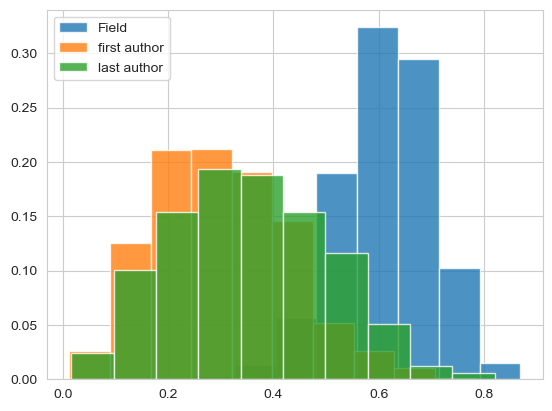

In [276]:
plt.hist(df_pw["context"], weights=[1 / len(df_pw)] * len(df_pw), alpha=0.8, label="Field")
plt.hist(df_pw_f["context"], weights=[1 / len(df_pw_f)] * len(df_pw_f), alpha=0.8, label="first author")
plt.hist(df_pw_l["context"], weights=[1 / len(df_pw_l)] * len(df_pw_l), alpha=0.8, label='last author')
plt.legend()
plt.show()

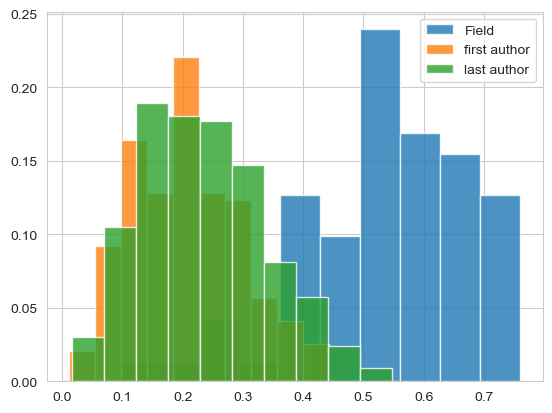

In [279]:
df_op = df_pw[df_pw['cluster'] == 1]
plt.hist(df_op["context"], weights=[1 / len(df_op)] * len(df_op), alpha=0.8, label="Field")
df_op = df_pw_f[df_pw_f['cluster'] == 1]
plt.hist(df_op["context"], weights=[1 / len(df_op)] * len(df_op), alpha=0.8, label="first author")
df_op = df_pw_l[df_pw_l['cluster'] == 1]
plt.hist(df_op["context"], weights=[1 / len(df_op)] * len(df_op), alpha=0.8, label='last author')
plt.legend()
plt.show()

In [284]:
df_op = df_pw
y = df_op['function']
X_cols = ['structure', 'context']
#X = sm.add_constant(df_op[X_cols])
X = df_op[X_cols]

lm2 = sm.OLS(y, X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               function   R-squared (uncentered):                   0.899
Model:                            OLS   Adj. R-squared (uncentered):              0.899
Method:                 Least Squares   F-statistic:                          1.786e+04
Date:                Thu, 07 Mar 2024   Prob (F-statistic):                        0.00
Time:                        18:16:25   Log-Likelihood:                          400.75
No. Observations:                4000   AIC:                                     -797.5
Df Residuals:                    3998   BIC:                                     -784.9
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
structure      0.8315      0.033     25.212      0.000       0.767       0.896
context        0.9923      0.006    164.732      0.000       0.981       1.004
==============================================================================
Omnibus:                       42.206   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.180
Skew:                          -0.232   Prob(JB):                     2.55e-10
Kurtosis:                       3.221   Cond. No.                         5.92
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [285]:
df_op = df_pw_f
y = df_op['function']
X_cols = ['structure', 'context']
#X = sm.add_constant(df_op[X_cols])
X = df_op[X_cols]

lm2 = sm.OLS(y, X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               function   R-squared (uncentered):                   0.841
Model:                            OLS   Adj. R-squared (uncentered):              0.841
Method:                 Least Squares   F-statistic:                              1959.
Date:                Thu, 07 Mar 2024   Prob (F-statistic):                   6.65e-296
Time:                        18:16:36   Log-Likelihood:                         -147.75
No. Observations:                 740   AIC:                                      299.5
Df Residuals:                     738   BIC:                                      308.7
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
structure      0.8352      0.052     16.119      0.000       0.734       0.937
context        1.3846      0.050     27.588      0.000       1.286       1.483
==============================================================================
Omnibus:                       18.966   Durbin-Watson:                   1.253
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.459
Skew:                           0.299   Prob(JB):                     0.000267
Kurtosis:                       2.581   Cond. No.                         2.67
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [286]:
df_op = df_pw_l
y = df_op['function']
X_cols = ['structure', 'context']
#X = sm.add_constant(df_op[X_cols])
X = df_op[X_cols]

lm2 = sm.OLS(y, X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               function   R-squared (uncentered):                   0.842
Model:                            OLS   Adj. R-squared (uncentered):              0.842
Method:                 Least Squares   F-statistic:                              4005.
Date:                Thu, 07 Mar 2024   Prob (F-statistic):                        0.00
Time:                        18:18:25   Log-Likelihood:                         -402.30
No. Observations:                1504   AIC:                                      808.6
Df Residuals:                    1502   BIC:                                      819.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
structure      0.7639      0.039     19.573      0.000       0.687       0.840
context        1.3167      0.035     37.729      0.000       1.248       1.385
==============================================================================
Omnibus:                       30.006   Durbin-Watson:                   1.402
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.274
Skew:                           0.345   Prob(JB):                     1.62e-07
Kurtosis:                       2.844   Cond. No.                         2.96
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [287]:
from statsmodels.stats.mediation import Mediation

In [644]:
df_op = df_pw
y = df_op['context']
X_cols = ['structure']
X = sm.add_constant(df_op[X_cols])
mediator_model = sm.OLS(y, X)

# For the second step of the mediation model, we can add in other predictors.
y = df_op['function']
X_cols = ['structure', 'context']
X = sm.add_constant(df_op[X_cols])
outcome_model = sm.OLS(y, X)

med = Mediation(outcome_model=outcome_model, mediator_model=mediator_model,
                exposure='structure', mediator='context').fit()
print("General Distribution: Structure(Exposure)-Context(Mediator)-Function(y)\n")
print(med.summary())

General Distribution: Structure(Exposure)-Context(Mediator)-Function(y)

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.079740        0.073813        0.085637      0.0
ACME (treated)            0.079740        0.073813        0.085637      0.0
ADE (control)             0.818281        0.800300        0.837495      0.0
ADE (treated)             0.818281        0.800300        0.837495      0.0
Total effect              0.898021        0.879589        0.917220      0.0
Prop. mediated (control)  0.088788        0.082382        0.095229      0.0
Prop. mediated (treated)  0.088788        0.082382        0.095229      0.0
ACME (average)            0.079740        0.073813        0.085637      0.0
ADE (average)             0.818281        0.800300        0.837495      0.0
Prop. mediated (average)  0.088788        0.082382        0.095229      0.0


In [645]:
df_op = df_pw_f
y = df_op['context']
X_cols = ['structure']
X = sm.add_constant(df_op[X_cols])
mediator_model = sm.OLS(y, X)

# For the second step of the mediation model, we can add in other predictors.
y = df_op['function']
X_cols = ['structure', 'context']
X = sm.add_constant(df_op[X_cols])
outcome_model = sm.OLS(y, X)

med = Mediation(outcome_model=outcome_model, mediator_model=mediator_model,
                exposure='structure', mediator='context').fit()
print("First Author: Structure(Exposure)-Context(Mediator)-Function(y)\n")
print(med.summary())

First Author: Structure(Exposure)-Context(Mediator)-Function(y)

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.280965        0.241408        0.320430      0.0
ACME (treated)            0.280965        0.241408        0.320430      0.0
ADE (control)             0.927956        0.862909        0.992685      0.0
ADE (treated)             0.927956        0.862909        0.992685      0.0
Total effect              1.208921        1.148507        1.273899      0.0
Prop. mediated (control)  0.232473        0.200535        0.263549      0.0
Prop. mediated (treated)  0.232473        0.200535        0.263549      0.0
ACME (average)            0.280965        0.241408        0.320430      0.0
ADE (average)             0.927956        0.862909        0.992685      0.0
Prop. mediated (average)  0.232473        0.200535        0.263549      0.0


In [646]:
df_op = df_pw_l
y = df_op['context']
X_cols = ['structure']
X = sm.add_constant(df_op[X_cols])
mediator_model = sm.OLS(y, X)

# For the second step of the mediation model, we can add in other predictors.
y = df_op['function']
X_cols = ['structure', 'context']
X = sm.add_constant(df_op[X_cols])
outcome_model = sm.OLS(y, X)

med = Mediation(outcome_model=outcome_model, mediator_model=mediator_model,
                exposure='structure', mediator='context').fit()
print("Last Author: Structure(Exposure)-Context(Mediator)-Function(y)\n")
print(med.summary())

Last Author: Structure(Exposure)-Context(Mediator)-Function(y)

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.298002        0.266275        0.333007      0.0
ACME (treated)            0.298002        0.266275        0.333007      0.0
ADE (control)             0.719414        0.667518        0.772711      0.0
ADE (treated)             0.719414        0.667518        0.772711      0.0
Total effect              1.017416        0.968069        1.068484      0.0
Prop. mediated (control)  0.292858        0.260762        0.325502      0.0
Prop. mediated (treated)  0.292858        0.260762        0.325502      0.0
ACME (average)            0.298002        0.266275        0.333007      0.0
ADE (average)             0.719414        0.667518        0.772711      0.0
Prop. mediated (average)  0.292858        0.260762        0.325502      0.0


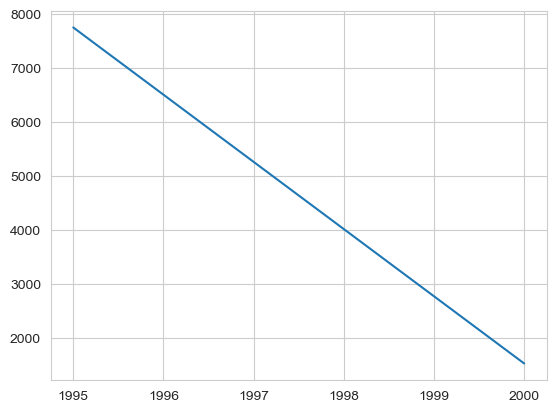

In [24]:
pap_vol = []
for i in range(1995, 2005, 5):
    df_op = df_para[(df_para.year >= i) & (df_para.year < i + 5)]
    pap_vol.append(len(df_op))

plt.plot(range(1995, 2005, 5), pap_vol)

In [565]:
%%time
f_auth_counts = sorted(Counter(df_para.f_auth).items(), key=lambda x: x[1], reverse=True)
l_auth_counts = sorted(Counter(df_para.l_auth).items(), key=lambda x: x[1], reverse=True)

authors_lists = [x[0] for x in f_auth_counts if x[1] >= 3]

pair_a_f = []
pair_b_f = []

for i in tqdm(authors_lists):
    df_op = df_para[df_para['f_auth'] == i].sort_values(by='year', ascending=True)
    for j in range(len(df_op) - 1):
        id1 = df_op['pmid'].iloc[j]
        id2 = df_op['pmid'].iloc[j + 1]

        if id1 in set(df_p2c['pmid']) and id2 in set(df_p2c['pmid']):
            pair_a_f.append(id1)
            pair_b_f.append(id2)

df_first = pd.DataFrame({
    "A": pair_a_f,
    "B": pair_b_f
})

authors_lists = [x[0] for x in l_auth_counts if x[1] >= 3]

pair_a_l = []
pair_b_l = []

for i in tqdm(authors_lists):

    df_op = df_para[df_para['l_auth'] == i].sort_values(by='year', ascending=True)
    for j in range(len(df_op) - 1):
        id1 = df_op['pmid'].iloc[j]
        id2 = df_op['pmid'].iloc[j + 1]

        if id1 in set(df_p2c['pmid']) and id2 in set(df_p2c['pmid']):
            pair_a_l.append(id1)
            pair_b_l.append(id2)

df_last = pd.DataFrame({
    "A": pair_a_l,
    "B": pair_b_l
})

100%|██████████| 1085/1085 [03:20<00:00,  5.42it/s]

CPU times: user 5min 27s, sys: 2.1 s, total: 5min 29s
Wall time: 5min 34s


In [567]:
%%time

struc_embd = []
func_embd = []
txt_embd = []
cluster = []
year = []

for A, B in tqdm([(df_first.iloc[i, 0], df_first.iloc[i, 1]) for i in range(len(df_first))]):
    p2c = df_p2c[df_p2c['pmid'] == A]
    smile_sp = smile_df[smile_df['iupac'].isin(set(p2c["chem_name"]))]
    struc_a = np.mean(np.array(list(smile_sp['embd'])), axis=0).round(3)
    func_a = np.mean(np.array(list(smile_sp['func_embd'])), axis=0).round(3)

    txt_a, cla, ya = text_df[text_df['pmid'] == int(A)].iloc[0][['ada_embedding', 'cluster', 'year']]

    p2c = df_p2c[df_p2c['pmid'] == B]
    smile_sp = smile_df[smile_df['iupac'].isin(set(p2c["chem_name"]))]
    struc_b = np.mean(np.array(list(smile_sp['embd'])), axis=0).round(3)
    func_b = np.mean(np.array(list(smile_sp['func_embd'])), axis=0).round(3)

    txt_b, clb, yb = text_df[text_df['pmid'] == int(B)].iloc[0][['ada_embedding', 'cluster', 'year']]

    struc_embd.append(distance.cosine(struc_a, struc_b))
    func_embd.append(distance.cosine(func_a, func_b))
    txt_embd.append(distance.cosine(txt_a, txt_b))
    cluster.append(cla == clb)
    year.append(np.abs(ya - yb))

df_pw_f = pd.DataFrame({
    "A": list(df_first["A"]),
    "B": list(df_first["B"]),
    "structure": struc_embd,
    "function": func_embd,
    "context": txt_embd,
    "cluster": cluster,
    "year": year
})

100%|██████████| 1979/1979 [00:05<00:00, 355.40it/s]

CPU times: user 4.61 s, sys: 923 ms, total: 5.53 s
Wall time: 7.04 s


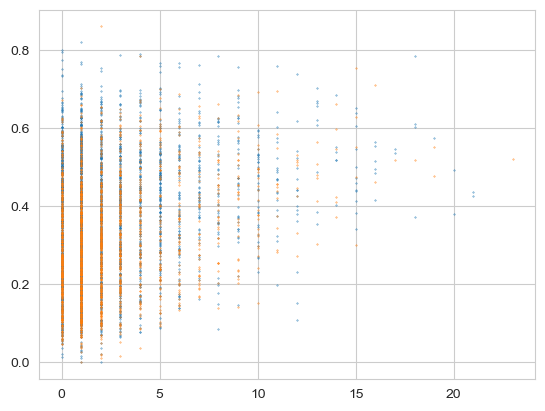

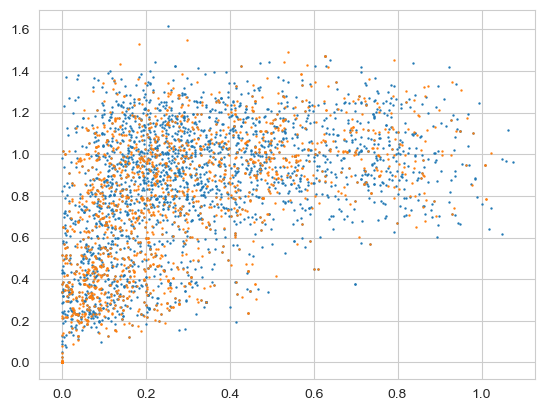

In [572]:
plt.scatter(df_pw_l["year"], df_pw_l["context"], s=0.1)
plt.scatter(df_pw_f["year"], df_pw_f["context"], s=0.1)
plt.show()

df_op = df_pw_l
plt.scatter(df_op["structure"], df_op["function"], s=0.5)
df_op = df_pw_f
plt.scatter(df_op["structure"], df_op["function"], s=0.5)

plt.show()

In [585]:
df_op = df_pw
y = df_op['context']
X_cols = ['structure', 'function']
X = sm.add_constant(df_op[X_cols])
#X = df_op[X_cols]

lm = sm.OLS(y, X).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                context   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     2117.
Date:                Fri, 08 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:10:58   Log-Likelihood:                 40678.
No. Observations:               40000   AIC:                        -8.135e+04
Df Residuals:                   39997   BIC:                        -8.132e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5377      0.001    412.137      0.000       0.535       0.540
structure      0.0209      0.004      5.059      0.000       0.013       0.029
function       0.1118      0.002     56.345      0.000       0.108       0.116
==============================================================================
Omnibus:                      481.725   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              573.836
Skew:                          -0.209   Prob(JB):                    2.47e-125
Kurtosis:                       3.413   Cond. No.                         11.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

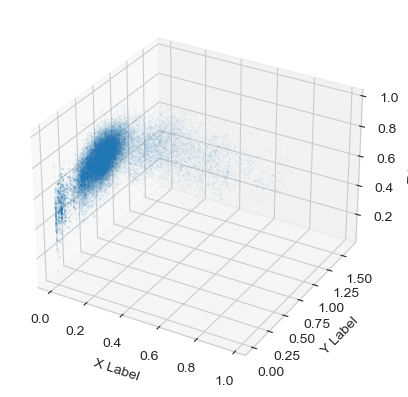

In [592]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pw['structure'], df_pw['function'], df_pw['context'], s=0.01)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [604]:
df_op = df_pw
y = df_op['function']
X_cols = ['structure']
X = sm.add_constant(df_op[X_cols])
mediator_model = sm.OLS(y, X)

# For the second step of the mediation model, we can add in other predictors.
y = df_op['context']
X_cols = ['structure', 'function']
X = sm.add_constant(df_op[X_cols])
outcome_model = sm.OLS(y, X)

med = Mediation(outcome_model=outcome_model, mediator_model=mediator_model,
                exposure='structure', mediator='function').fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.100453,0.096342,0.104560,0.0
ACME (treated),0.100453,0.096342,0.104560,0.0
ADE (control),0.021209,0.013056,0.029686,0.0
ADE (treated),0.021209,0.013056,0.029686,0.0
Total effect,0.121663,0.114506,0.129465,0.0
Prop. mediated (control),0.825840,0.768279,0.887195,0.0
Prop. mediated (treated),0.825840,0.768279,0.887195,0.0
ACME (average),0.100453,0.096342,0.104560,0.0
ADE (average),0.021209,0.013056,0.029686,0.0
Prop. mediated (average),0.825840,0.768279,0.887195,0.0


In [605]:
df_op = df_pw
y = df_op['context']
X_cols = ['structure']
X = sm.add_constant(df_op[X_cols])
mediator_model = sm.OLS(y, X)

# For the second step of the mediation model, we can add in other predictors.
y = df_op['function']
X_cols = ['structure', 'context']
X = sm.add_constant(df_op[X_cols])
outcome_model = sm.OLS(y, X)

med = Mediation(outcome_model=outcome_model, mediator_model=mediator_model,
                exposure='structure', mediator='context').fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.079834,0.074039,0.086080,0.0
ACME (treated),0.079834,0.074039,0.086080,0.0
ADE (control),0.818729,0.801080,0.836106,0.0
ADE (treated),0.818729,0.801080,0.836106,0.0
Total effect,0.898563,0.880811,0.915909,0.0
Prop. mediated (control),0.088712,0.082767,0.095443,0.0
Prop. mediated (treated),0.088712,0.082767,0.095443,0.0
ACME (average),0.079834,0.074039,0.086080,0.0
ADE (average),0.818729,0.801080,0.836106,0.0
Prop. mediated (average),0.088712,0.082767,0.095443,0.0


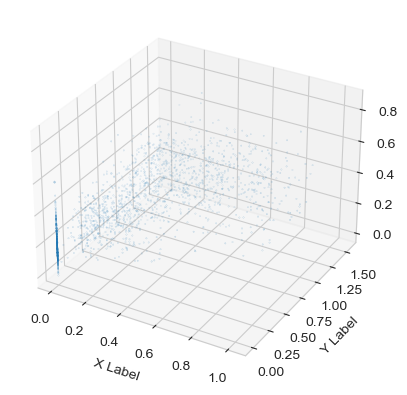

In [601]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pw_f['structure'], df_pw_f['function'], df_pw_f['context'], s=0.01)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [606]:
df_op = df_pw_f
y = df_op['function']
X_cols = ['structure']
X = sm.add_constant(df_op[X_cols])
mediator_model = sm.OLS(y, X)

# For the second step of the mediation model, we can add in other predictors.
y = df_op['context']
X_cols = ['structure', 'function']
X = sm.add_constant(df_op[X_cols])
outcome_model = sm.OLS(y, X)

med = Mediation(outcome_model=outcome_model, mediator_model=mediator_model,
                exposure='structure', mediator='function').fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.165984,0.146525,0.186129,0.0
ACME (treated),0.165984,0.146525,0.186129,0.0
ADE (control),0.137990,0.110193,0.165666,0.0
ADE (treated),0.137990,0.110193,0.165666,0.0
Total effect,0.303975,0.281210,0.326570,0.0
Prop. mediated (control),0.546397,0.479442,0.620868,0.0
Prop. mediated (treated),0.546397,0.479442,0.620868,0.0
ACME (average),0.165984,0.146525,0.186129,0.0
ADE (average),0.137990,0.110193,0.165666,0.0
Prop. mediated (average),0.546397,0.479442,0.620868,0.0


In [607]:
df_op = df_pw_f
y = df_op['context']
X_cols = ['structure']
X = sm.add_constant(df_op[X_cols])
mediator_model = sm.OLS(y, X)

# For the second step of the mediation model, we can add in other predictors.
y = df_op['function']
X_cols = ['structure', 'context']
X = sm.add_constant(df_op[X_cols])
outcome_model = sm.OLS(y, X)

med = Mediation(outcome_model=outcome_model, mediator_model=mediator_model,
                exposure='structure', mediator='context').fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.282364,0.243606,0.323821,0.0
ACME (treated),0.282364,0.243606,0.323821,0.0
ADE (control),0.925573,0.857508,0.993108,0.0
ADE (treated),0.925573,0.857508,0.993108,0.0
Total effect,1.207937,1.143809,1.275829,0.0
Prop. mediated (control),0.233945,0.201594,0.266253,0.0
Prop. mediated (treated),0.233945,0.201594,0.266253,0.0
ACME (average),0.282364,0.243606,0.323821,0.0
ADE (average),0.925573,0.857508,0.993108,0.0
Prop. mediated (average),0.233945,0.201594,0.266253,0.0


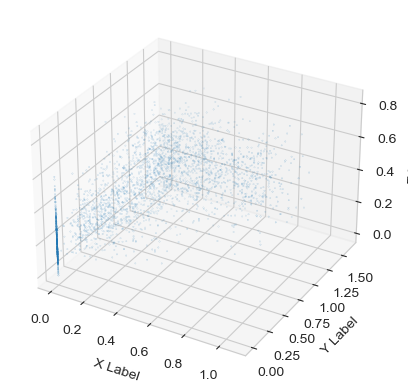

In [602]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pw_l['structure'], df_pw_l['function'], df_pw_l['context'], s=0.01)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [608]:
df_op = df_pw_l
y = df_op['function']
X_cols = ['structure']
X = sm.add_constant(df_op[X_cols])
mediator_model = sm.OLS(y, X)

# For the second step of the mediation model, we can add in other predictors.
y = df_op['context']
X_cols = ['structure', 'function']
X = sm.add_constant(df_op[X_cols])
outcome_model = sm.OLS(y, X)

med = Mediation(outcome_model=outcome_model, mediator_model=mediator_model,
                exposure='structure', mediator='function').fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.155667,0.140597,0.171931,0.0
ACME (treated),0.155667,0.140597,0.171931,0.0
ADE (control),0.163684,0.141800,0.186498,0.0
ADE (treated),0.163684,0.141800,0.186498,0.0
Total effect,0.319351,0.300672,0.338042,0.0
Prop. mediated (control),0.487534,0.436995,0.542004,0.0
Prop. mediated (treated),0.487534,0.436995,0.542004,0.0
ACME (average),0.155667,0.140597,0.171931,0.0
ADE (average),0.163684,0.141800,0.186498,0.0
Prop. mediated (average),0.487534,0.436995,0.542004,0.0


In [609]:
df_op = df_pw_l
y = df_op['context']
X_cols = ['structure']
X = sm.add_constant(df_op[X_cols])
mediator_model = sm.OLS(y, X)

# For the second step of the mediation model, we can add in other predictors.
y = df_op['function']
X_cols = ['structure', 'context']
X = sm.add_constant(df_op[X_cols])
outcome_model = sm.OLS(y, X)

med = Mediation(outcome_model=outcome_model, mediator_model=mediator_model,
                exposure='structure', mediator='context').fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.297869,0.266790,0.332912,0.0
ACME (treated),0.297869,0.266790,0.332912,0.0
ADE (control),0.721471,0.672466,0.771508,0.0
ADE (treated),0.721471,0.672466,0.771508,0.0
Total effect,1.019340,0.972551,1.065607,0.0
Prop. mediated (control),0.292284,0.262926,0.326799,0.0
Prop. mediated (treated),0.292284,0.262926,0.326799,0.0
ACME (average),0.297869,0.266790,0.332912,0.0
ADE (average),0.721471,0.672466,0.771508,0.0
Prop. mediated (average),0.292284,0.262926,0.326799,0.0


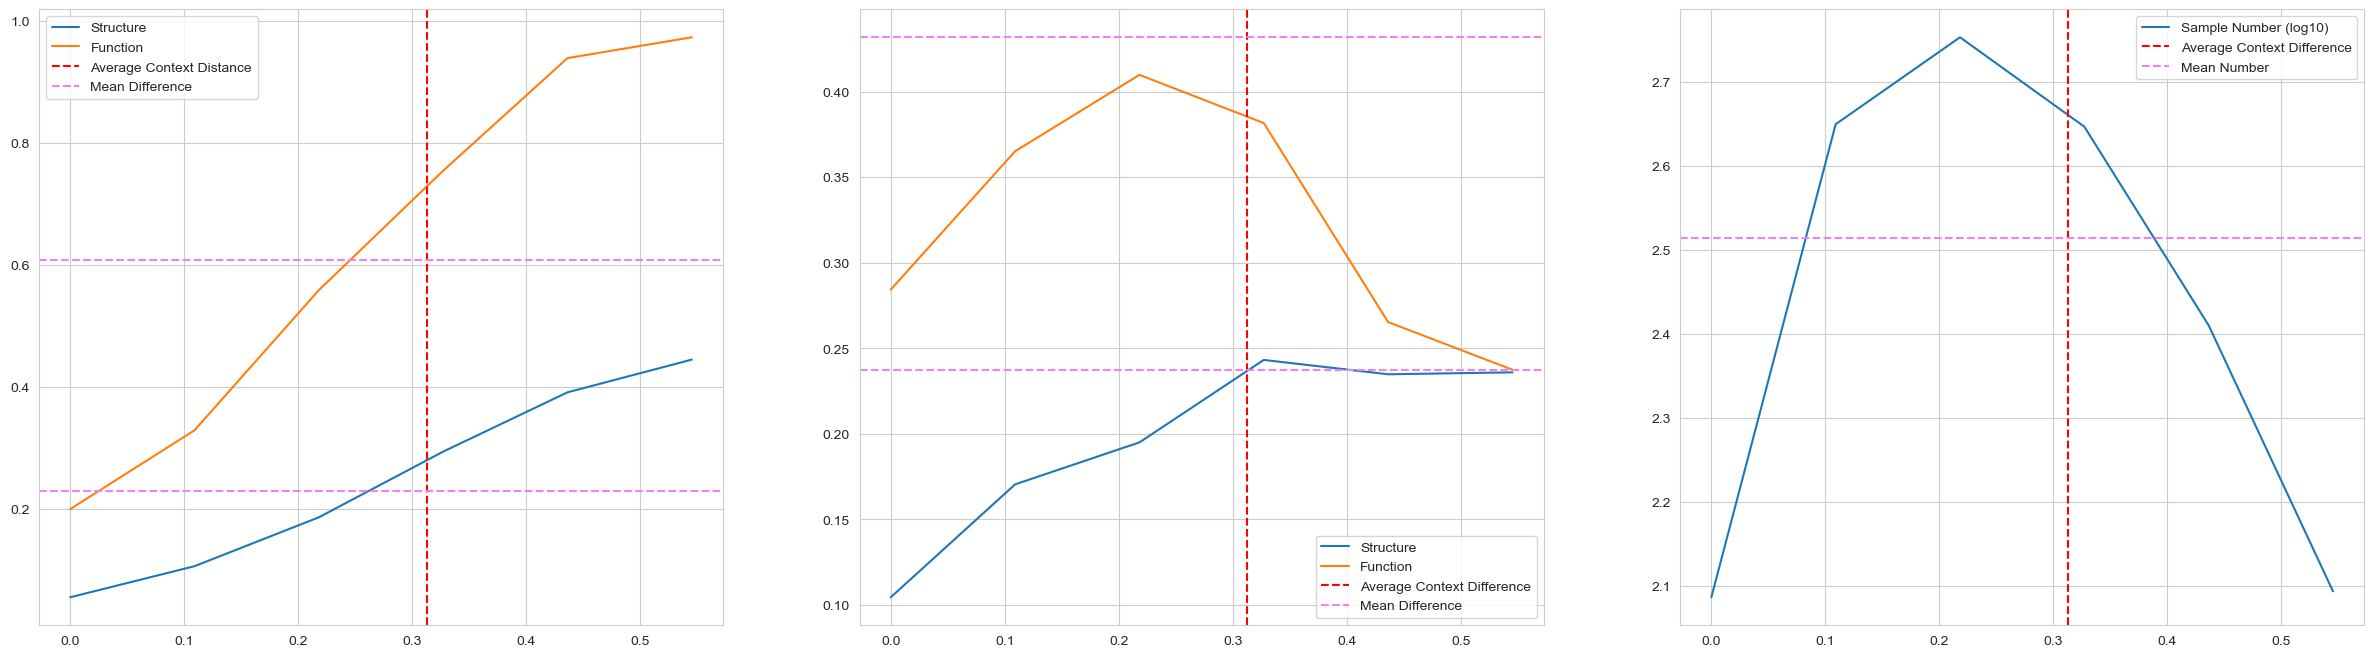

In [577]:
func_mean = []
struc_mean = []

func_std = []
struc_std = []

thre = np.linspace(0, 1.2, num=12)
t_list = []
num_list = []

for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw_f[(df_pw_f['context'] >= thre[i]) & (df_pw_f['context'] < thre[i + 1])]

    y = df_op['function']
    x = df_op['structure']

    if len(y) < 50:
        continue

    t_list.append(y_p)
    num_list.append(len(y))
    func_mean.append(y.mean())
    func_std.append(y.std())

    struc_mean.append(x.mean())
    struc_std.append(x.std())

avg_struc = df_pw_f["structure"].mean()
std_struc = df_pw_f["structure"].std()
avg_func = df_pw_f["function"].mean()
std_func = df_pw_f["function"].std()
avg_text = df_pw_f["context"].mean()
std_text = df_pw_f["context"].std()
avg_num = np.log10(np.array(num_list).mean())

fig = plt.figure(figsize=(30, 8))
ax1 = plt.subplot(1, 3, 1)
ax1.plot(t_list, struc_mean, label='Structure')
ax1.plot(t_list, func_mean, label='Function')
ax1.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Distance')
ax1.axhline(y=avg_struc, color='violet', linestyle='--', label='Mean Difference')
ax1.axhline(y=avg_func, color='violet', linestyle='--')
ax1.legend()

ax2 = plt.subplot(1, 3, 2)
ax2.plot(t_list, struc_std, label='Structure')
ax2.plot(t_list, func_std, label='Function')
ax2.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Difference')
ax2.axhline(y=std_struc, color='violet', linestyle='--', label='Mean Difference')
ax2.axhline(y=std_func, color='violet', linestyle='--')
ax2.legend()

ax3 = plt.subplot(1, 3, 3)
ax3.plot(t_list, np.log10(np.array(num_list)), label="Sample Number (log10)")
ax3.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Difference')
ax3.axhline(y=avg_num, color='violet', linestyle='--', label='Mean Number')
ax3.legend()

plt.show()

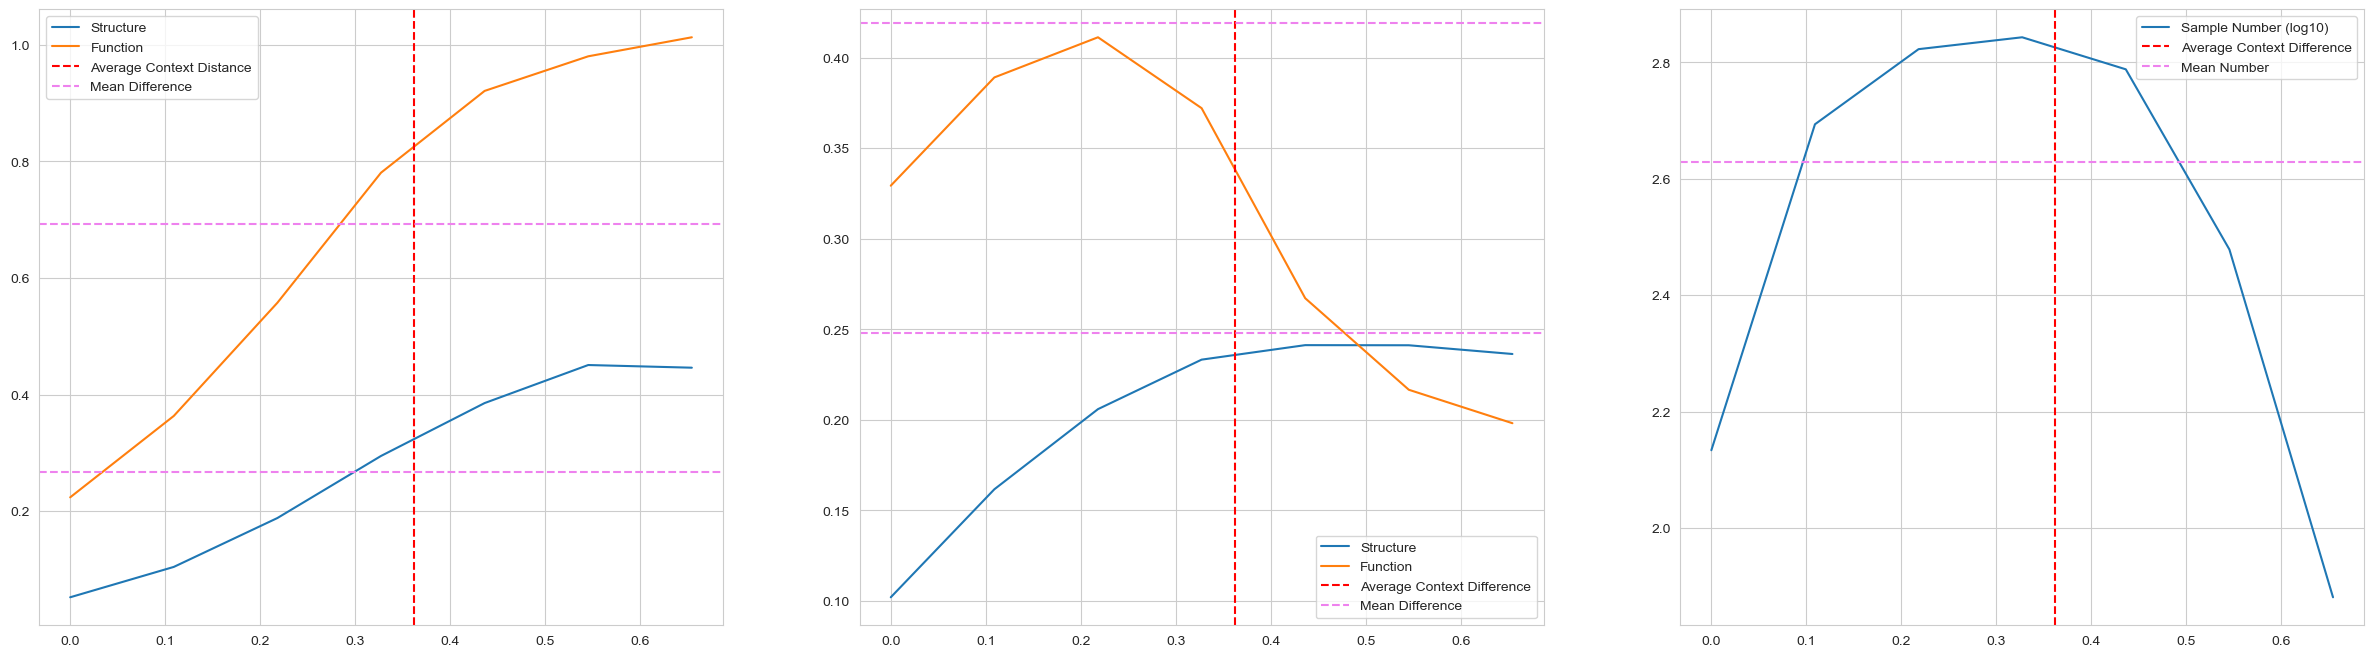

In [578]:
func_mean = []
struc_mean = []

func_std = []
struc_std = []

thre = np.linspace(0., 1.2, num=12)
t_list = []
num_list = []

for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw_l[(df_pw_l['context'] >= thre[i]) & (df_pw_l['context'] < thre[i + 1])]

    y = df_op['function']
    x = df_op['structure']

    if len(y) < 50:
        continue

    t_list.append(y_p)
    num_list.append(len(y))
    func_mean.append(y.mean())
    func_std.append(y.std())

    struc_mean.append(x.mean())
    struc_std.append(x.std())

avg_struc = df_pw_l["structure"].mean()
std_struc = df_pw_l["structure"].std()
avg_func = df_pw_l["function"].mean()
std_func = df_pw_l["function"].std()
avg_text = df_pw_l["context"].mean()
std_text = df_pw_l["context"].std()
avg_num = np.log10(np.array(num_list).mean())

fig = plt.figure(figsize=(30, 8))
ax1 = plt.subplot(1, 3, 1)
ax1.plot(t_list, struc_mean, label='Structure')
ax1.plot(t_list, func_mean, label='Function')
ax1.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Distance')
ax1.axhline(y=avg_struc, color='violet', linestyle='--', label='Mean Difference')
ax1.axhline(y=avg_func, color='violet', linestyle='--')
ax1.legend()

ax2 = plt.subplot(1, 3, 2)
ax2.plot(t_list, struc_std, label='Structure')
ax2.plot(t_list, func_std, label='Function')
ax2.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Difference')
ax2.axhline(y=std_struc, color='violet', linestyle='--', label='Mean Difference')
ax2.axhline(y=std_func, color='violet', linestyle='--')
ax2.legend()

ax3 = plt.subplot(1, 3, 3)
ax3.plot(t_list, np.log10(np.array(num_list)), label="Sample Number (log10)")
ax3.axvline(x=avg_text, color='r', linestyle='--', label='Average Context Difference')
ax3.axhline(y=avg_num, color='violet', linestyle='--', label='Mean Number')
ax3.legend()

plt.show()

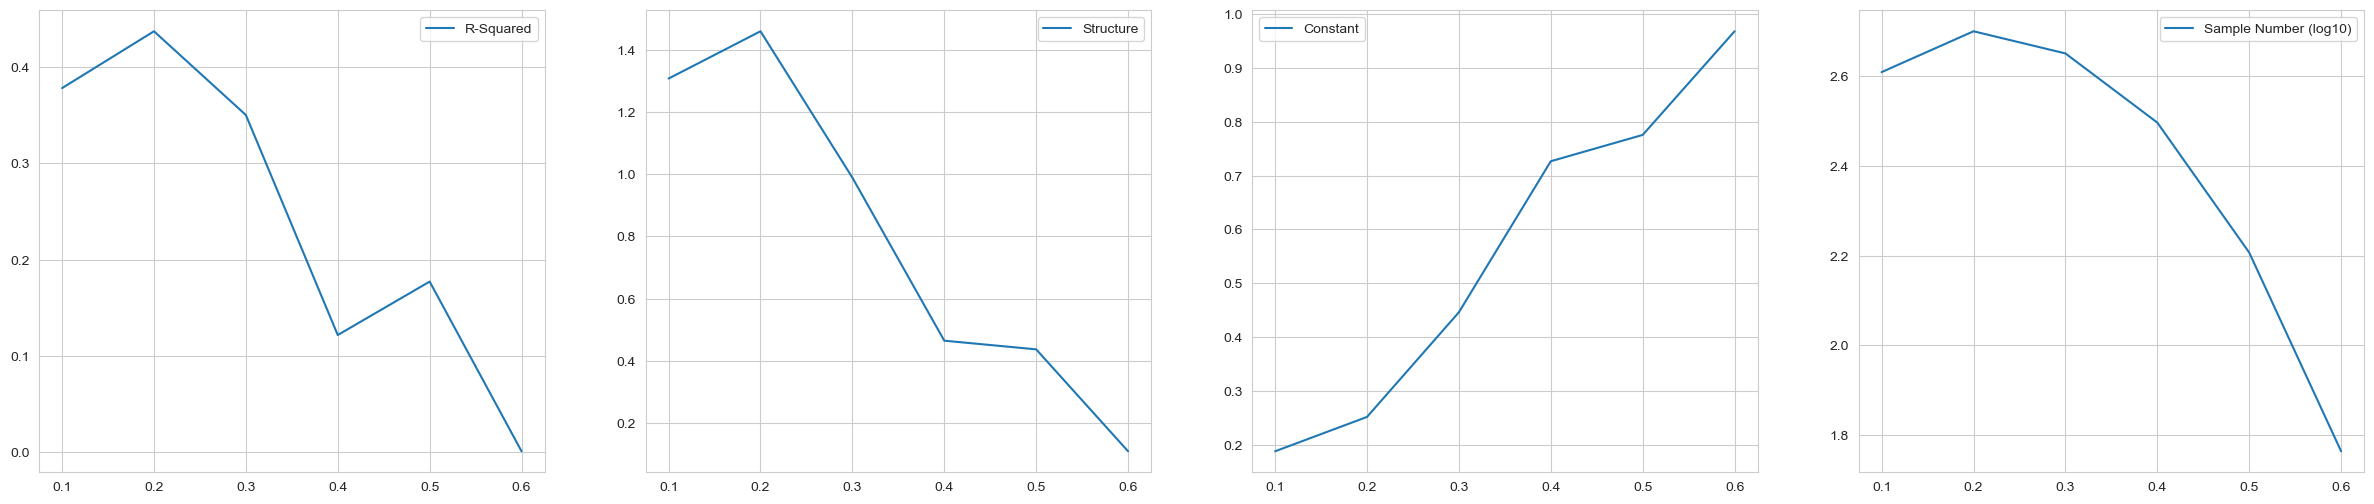

In [580]:
r_squared = []
const = []
para_0 = []
thre = np.linspace(0.1, 1.2, num=12)
t_list = []
num = []

for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw_f[(df_pw_f['context'] >= thre[i]) & (df_pw_f['context'] < thre[i + 1])]
    y = df_op['function']

    if len(y) < 50:
        continue

    X_cols = ['structure']
    X = sm.add_constant(df_op[X_cols])
    #X = df_op[X_cols]

    lm2 = sm.OLS(y, X).fit()
    t_list.append(y_p)
    num.append(len(y))
    r_squared.append(lm2.rsquared_adj)
    const.append(lm2.params.iloc[0])
    para_0.append(lm2.params.iloc[1])

fig = plt.figure(figsize=(30, 6))
ax1 = plt.subplot(1, 4, 1)
ax1.plot(t_list, r_squared, label='R-Squared')
ax1.legend()
ax2 = plt.subplot(1, 4, 2)
ax2.plot(t_list, para_0, label='Structure')
ax2.legend()
ax3 = plt.subplot(1, 4, 3)
ax3.plot(t_list, const, label='Constant')
ax3.legend()
ax4 = plt.subplot(1, 4, 4)
ax4.plot(t_list, np.log10(np.array(num)), label='Sample Number (log10)')
ax4.legend()
plt.show()

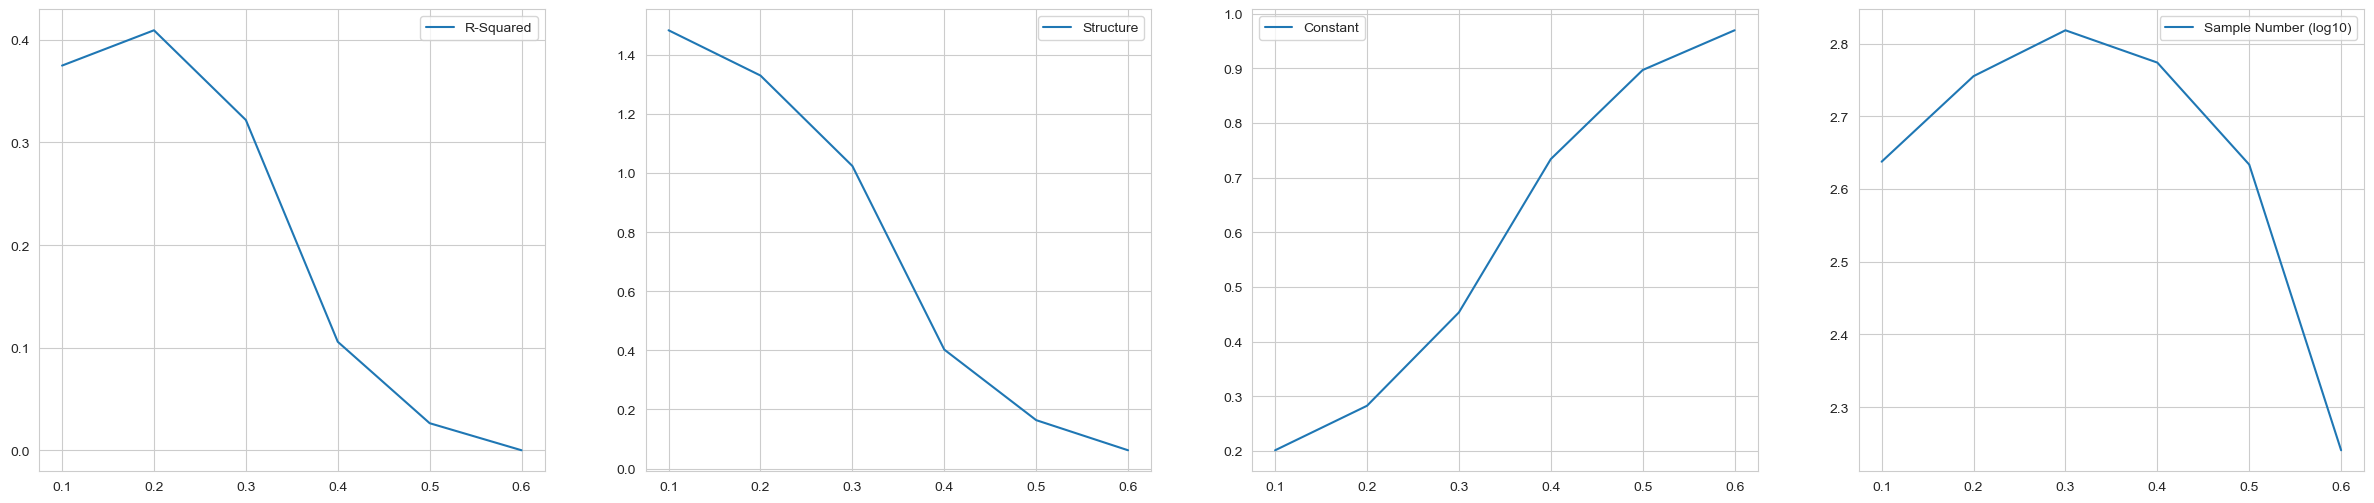

In [581]:
r_squared = []
const = []
para_0 = []
thre = np.linspace(0.1, 1.2, num=12)
t_list = []
num = []

for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw_l[(df_pw_l['context'] >= thre[i]) & (df_pw_l['context'] < thre[i + 1])]
    y = df_op['function']

    if len(y) < 50:
        continue

    X_cols = ['structure']
    X = sm.add_constant(df_op[X_cols])
    #X = df_op[X_cols]

    lm2 = sm.OLS(y, X).fit()
    t_list.append(y_p)
    num.append(len(y))
    r_squared.append(lm2.rsquared_adj)
    const.append(lm2.params.iloc[0])
    para_0.append(lm2.params.iloc[1])

fig = plt.figure(figsize=(30, 6))
ax1 = plt.subplot(1, 4, 1)
ax1.plot(t_list, r_squared, label='R-Squared')
ax1.legend()
ax2 = plt.subplot(1, 4, 2)
ax2.plot(t_list, para_0, label='Structure')
ax2.legend()
ax3 = plt.subplot(1, 4, 3)
ax3.plot(t_list, const, label='Constant')
ax3.legend()
ax4 = plt.subplot(1, 4, 4)
ax4.plot(t_list, np.log10(np.array(num)), label='Sample Number (log10)')
ax4.legend()
plt.show()

In [568]:
%%time

struc_embd = []
func_embd = []
txt_embd = []
cluster = []
year = []

for A, B in tqdm([(df_last.iloc[i, 0], df_last.iloc[i, 1]) for i in range(len(df_last))]):
    p2c = df_p2c[df_p2c['pmid'] == A]
    smile_sp = smile_df[smile_df['iupac'].isin(set(p2c["chem_name"]))]
    struc_a = np.mean(np.array(list(smile_sp['embd'])), axis=0).round(3)
    func_a = np.mean(np.array(list(smile_sp['func_embd'])), axis=0).round(3)

    txt_a, cla, ya = text_df[text_df['pmid'] == int(A)].iloc[0][['ada_embedding', 'cluster', 'year']]

    p2c = df_p2c[df_p2c['pmid'] == B]
    smile_sp = smile_df[smile_df['iupac'].isin(set(p2c["chem_name"]))]
    struc_b = np.mean(np.array(list(smile_sp['embd'])), axis=0).round(3)
    func_b = np.mean(np.array(list(smile_sp['func_embd'])), axis=0).round(3)

    txt_b, clb, yb = text_df[text_df['pmid'] == int(B)].iloc[0][['ada_embedding', 'cluster', 'year']]

    struc_embd.append(distance.cosine(struc_a, struc_b))
    func_embd.append(distance.cosine(func_a, func_b))
    txt_embd.append(distance.cosine(txt_a, txt_b))
    cluster.append(cla == clb)
    year.append(np.abs(ya - yb))

df_pw_l = pd.DataFrame({
    "A": list(df_last["A"]),
    "B": list(df_last["B"]),
    "structure": struc_embd,
    "function": func_embd,
    "context": txt_embd,
    "cluster": cluster,
    "year": year
})

100%|██████████| 2996/2996 [00:07<00:00, 412.05it/s]


CPU times: user 7.01 s, sys: 176 ms, total: 7.19 s
Wall time: 7.34 s


In [ ]:
%%time

struc_embd = []
func_embd = []
txt_embd = []
cluster = []
year = []

for A, B in tqdm([(df_first.iloc[i, 0], df_first.iloc[i, 1]) for i in range(len(df_first))]):
    p2c = df_p2c[df_p2c['pmid'] == A]
    smile_sp = smile_df[smile_df['iupac'].isin(set(p2c["chem_name"]))]
    struc_a = np.mean(np.array(list(smile_sp['embd'])), axis=0).round(3)
    func_a = np.mean(np.array(list(smile_sp['func_embd'])), axis=0).round(3)

    txt_a, cla, ya = text_df[text_df['pmid'] == int(A)].iloc[0][['ada_embedding', 'cluster', 'year']]

    p2c = df_p2c[df_p2c['pmid'] == B]
    smile_sp = smile_df[smile_df['iupac'].isin(set(p2c["chem_name"]))]
    struc_b = np.mean(np.array(list(smile_sp['embd'])), axis=0).round(3)
    func_b = np.mean(np.array(list(smile_sp['func_embd'])), axis=0).round(3)

    txt_b, clb, yb = text_df[text_df['pmid'] == int(B)].iloc[0][['ada_embedding', 'cluster', 'year']]

    struc_embd.append(distance.cosine(struc_a, struc_b))
    func_embd.append(distance.cosine(func_a, func_b))
    txt_embd.append(distance.cosine(txt_a, txt_b))
    cluster.append(cla == clb)
    year.append(np.abs(ya - yb))

df_pw_f = pd.DataFrame({
    "A": list(df_first["A"]),
    "B": list(df_first["B"]),
    "structure": struc_embd,
    "function": func_embd,
    "context": txt_embd,
    "cluster": cluster,
    "year": year
})

In [ ]:
for A, B in tqdm([(df_c.iloc[i, 0], df_c.iloc[i, 1]) for i in range(len(df_c))]):
    p2c = df_p2c[df_p2c['pmid'] == A]
    smile_sp = smile_df[smile_df['iupac'].isin(set(p2c["chem_name"]))]
    struc_a = np.mean(np.array(list(smile_sp['embd'])), axis=0).round(3)
    func_a = np.mean(np.array(list(smile_sp['func_embd'])), axis=0).round(3)

    txt_a, cla, ya = text_df[text_df['pmid'] == int(A)].iloc[0][['ada_embedding', 'cluster', 'year']]

    p2c = df_p2c[df_p2c['pmid'] == B]
    smile_sp = smile_df[smile_df['iupac'].isin(set(p2c["chem_name"]))]
    struc_b = np.mean(np.array(list(smile_sp['embd'])), axis=0).round(3)
    func_b = np.mean(np.array(list(smile_sp['func_embd'])), axis=0).round(3)

    txt_b, clb, yb = text_df[text_df['pmid'] == int(B)].iloc[0][['ada_embedding', 'cluster', 'year']]

    struc_embd.append(distance.cosine(struc_a, struc_b))
    func_embd.append(distance.cosine(func_a, func_b))
    txt_embd.append(distance.cosine(txt_a, txt_b))
    cluster.append(cla == clb)
    year.append(np.abs(ya - yb))

df_pw = pd.DataFrame({
    "A": list(df_c["A"]),
    "B": list(df_c["B"]),
    "structure": struc_embd,
    "function": func_embd,
    "context": txt_embd,
    "cluster": [int(i) for i in cluster],
    'year': year
})

df_pw.to_csv('pw_cor.csv', index=False)

In [260]:
struc_embd = []
func_embd = []
txt_embd = []
cluster = []

for idx, row in df_first.iterrows():

    if idx % 10 == 0:
        print(idx)

    p2c = df_p2c[df_p2c['pmid'] == row['A']]
    smile_sp = smile_df[smile_df['iupac'].isin(set(p2c["chem_name"]))]
    struc_a = np.mean(np.array(list(smile_sp['embd'])), axis=0).round(3)
    func_a = np.mean(np.array(list(smile_sp['func_embd'])), axis=0).round(3)

    txtstr, cla = text_df[text_df['pmid'] == int(row['A'])].iloc[0][['ada_embedding', 'cluster']]
    txt_a = np.array([float(x) for x in txtstr[1:-1].split(',')]).round(3)

    p2c = df_p2c[df_p2c['pmid'] == row['B']]
    smile_sp = smile_df[smile_df['iupac'].isin(set(p2c["chem_name"]))]
    struc_b = np.mean(np.array(list(smile_sp['embd'])), axis=0).round(3)
    func_b = np.mean(np.array(list(smile_sp['func_embd'])), axis=0).round(3)

    txtstr, clb = text_df[text_df['pmid'] == int(row['B'])].iloc[0][['ada_embedding', 'cluster']]
    txt_b = np.array([float(x) for x in txtstr[1:-1].split(',')]).round(3)

    struc_embd.append(distance.cosine(struc_a, struc_b))
    func_embd.append(distance.cosine(func_a, func_b))
    txt_embd.append(distance.cosine(txt_a, txt_b))
    cluster.append(cla == clb)

df_pw_f = pd.DataFrame({
    "A": list(df_first["A"]),
    "B": list(df_first["B"]),
    "structure": struc_embd,
    "function": func_embd,
    "context": txt_embd,
    "cluster": cluster
})


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730


In [261]:
%%time
f_auth_counts = sorted(Counter(df_para.f_auth).items(), key=lambda x: x[1], reverse=True)
l_auth_counts = sorted(Counter(df_para.l_auth).items(), key=lambda x: x[1], reverse=True)

authors_lists = [x[0] for x in l_auth_counts if x[1] >= 5]

pair_a_l = []
pair_b_l = []

for i in tqdm(authors_lists):
    df_op = df_para[df_para['l_auth'] == i].sort_values(by='year', ascending=True)
    for j in range(len(df_op) - 1):
        id1 = df_op['pmid'].iloc[j]
        id2 = df_op['pmid'].iloc[j + 1]

        if id1 in set(df_p2c['pmid']) and id2 in set(df_p2c['pmid']):
            pair_a_l.append(id1)
            pair_b_l.append(id2)

            if len(pair_a) >= 1000:
                break


100%|██████████| 286/286 [01:42<00:00,  2.79it/s]

CPU times: user 1min 38s, sys: 842 ms, total: 1min 39s
Wall time: 1min 42s


In [262]:
df_last = pd.DataFrame({
    "A": pair_a_l,
    "B": pair_b_l
})

struc_embd = []
func_embd = []
txt_embd = []
cluster = []

for idx, row in df_last.iterrows():

    if idx % 10 == 0:
        print(idx)

    p2c = df_p2c[df_p2c['pmid'] == row['A']]
    smile_sp = smile_df[smile_df['iupac'].isin(set(p2c["chem_name"]))]
    struc_a = np.mean(np.array(list(smile_sp['embd'])), axis=0).round(3)
    func_a = np.mean(np.array(list(smile_sp['func_embd'])), axis=0).round(3)

    txtstr, cla = text_df[text_df['pmid'] == int(row['A'])].iloc[0][['ada_embedding', 'cluster']]
    txt_a = np.array([float(x) for x in txtstr[1:-1].split(',')]).round(3)

    p2c = df_p2c[df_p2c['pmid'] == row['B']]
    smile_sp = smile_df[smile_df['iupac'].isin(set(p2c["chem_name"]))]
    struc_b = np.mean(np.array(list(smile_sp['embd'])), axis=0).round(3)
    func_b = np.mean(np.array(list(smile_sp['func_embd'])), axis=0).round(3)

    txtstr, clb = text_df[text_df['pmid'] == int(row['B'])].iloc[0][['ada_embedding', 'cluster']]
    txt_b = np.array([float(x) for x in txtstr[1:-1].split(',')]).round(3)

    struc_embd.append(distance.cosine(struc_a, struc_b))
    func_embd.append(distance.cosine(func_a, func_b))
    txt_embd.append(distance.cosine(txt_a, txt_b))
    cluster.append(cla == clb)

df_pw_l = pd.DataFrame({
    "A": list(df_last["A"]),
    "B": list(df_last["B"]),
    "structure": struc_embd,
    "function": func_embd,
    "context": txt_embd,
    "cluster": cluster
})


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500


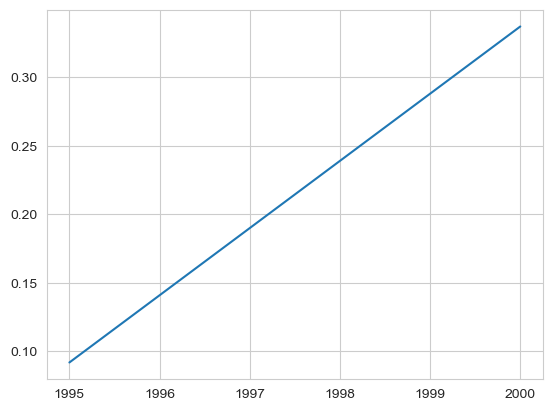

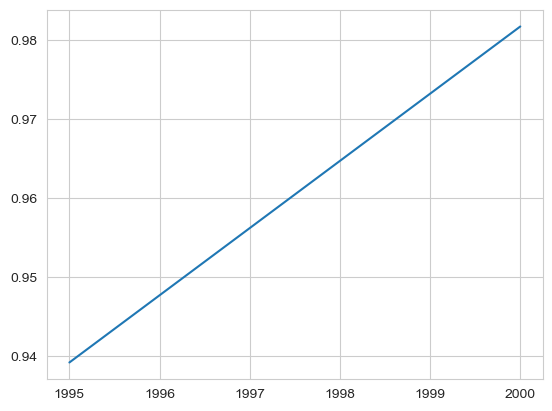

In [25]:
clu_ents = []
clu_vol = []
afi_ents = []
afi_vol = []
for i in range(1995, 2005, 5):
    df_op = df_para[(df_para.year >= i) & (df_para.year < i + 5)]
    clu_ents.append(entropy(df_op['cluster']))
    clu_vol.append(len(df_op['cluster'].unique()) / len(df_op['cluster']))
    afi_ents.append(entropy(df_op['affiliation']))
    afi_vol.append(len(df_op['affiliation'].unique()) / len(df_op['affiliation']))
plt.plot(range(1995, 2005, 5), clu_vol)
plt.show()
plt.plot(range(1995, 2005, 5), afi_vol)
plt.show()

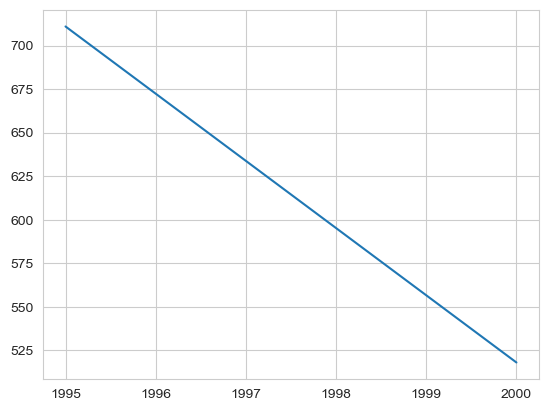

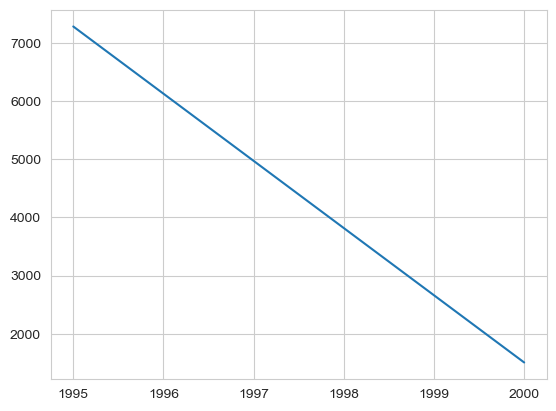

In [17]:
clu_ents = []
clu_vol = []
afi_ents = []
afi_vol = []
for i in range(1995, 2005, 5):
    df_op = df_para[(df_para.year >= i) & (df_para.year < i + 5)]
    clu_ents.append(entropy(df_op['cluster']))
    clu_vol.append(len(df_op['cluster'].unique()))
    afi_ents.append(entropy(df_op['affiliation']))
    afi_vol.append(len(df_op['affiliation'].unique()))
plt.plot(range(1995, 2005, 5), clu_vol)
plt.show()
plt.plot(range(1995, 2005, 5), afi_vol)
plt.show()